# 2D Material Bandgaps

In this notebook, we provide code to reproduce the results shown in our manuscript on the problem of predicting the badgap of 2D Materials using compositional and structural features.

In [1]:
import functools
import pickle
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tpot
import sklearn
import optuna
import xgboost
import pymatgen
import xenonpy.descriptor
from tqdm.notebook import tqdm 
import sys, os

sys.path.append("../../../")
import DigitalEcosystem.utils.figures
from DigitalEcosystem.utils.functional import except_with_default_value
from DigitalEcosystem.utils.misc import matminer_descriptors
from DigitalEcosystem.utils.misc import root_mean_squared_error
from DigitalEcosystem.utils.element_symbols import noble_gases, f_block_elements, synthetic_elements_in_d_block

from IPython.display import Latex

pd.options.mode.chained_assignment = None 
tqdm.pandas()

In [2]:
# Random seeds for reproducibility
RANDOM_SEED = 42
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
# Plot Configuration
plt.rcParams["figure.figsize"] = (15, 15)
plt.rcParams["font.size"] = 32

# Read in the Data

To start, we'll read in the data. Then, we'll filter out the dataset with the following rules:

1. No elements from the f-block, anything larger than U, or noble gases
2. Decomposition energies must be below 0.5 eV
3. Exfoliation energies must be strictly positive

Also, because we utilize the Materials Project bandgap as a descriptor for the XGBoost and TPOT models, we necessarily must remove the bottom-up materials from the dataset. This is because only the top-down materials have corresponding entries on the Materials Project.

In [4]:
data = pd.read_pickle('../feature_engineering/full_featurized_data.pkl')


# Drop any missing entries
target_column = ["bandgap (eV)"]
data = data[data[target_column[0]].notna()]

# # Drop anything in the f-block, larger than U, and noble gases
bad_elements = noble_gases + f_block_elements + synthetic_elements_in_d_block
element_mask = data['atoms_object (unitless)'].apply(lambda atoms: all([forbidden not in atoms.get_chemical_symbols() for forbidden in bad_elements]))

# Drop anything that decomposes
decomposition_mask = data['decomposition_energy (eV/atom)'] < 0.5

# Drop things with non-strictly-positive exfoliation energies
exfol_mask = data['exfoliation_energy_per_atom (eV/atom)'] > 0

data = data[element_mask & decomposition_mask & exfol_mask]

# A parent Materials Project structure is not defined for the bottom-up materials. We waste our bandwith looking these up, so let's remove them.
data = data[data['discovery_process (unitless)'] != 'bottom-up']

Next up we'll query the Materials Project through PyMatGen for the bandgap of each material

In [5]:
rester = pymatgen.ext.matproj.MPRester(api_key="4HnKZpQ4ekwrO54lpvkM")


@except_with_default_value(default_return=None)
def get_mp_bandgap(structure):
    mp_id = DigitalEcosystem.utils.misc.get_parent_structure_id(structure)
    
    result = rester.get_data(mp_id, prop='band_gap')[0]['band_gap']
    return result
    
data['mp_bandgap'] = data['2dm_id (unitless)'].progress_apply(get_mp_bandgap)

  0%|          | 0/1879 [00:00<?, ?it/s]

KeyboardInterrupt: 


The above featurization takes a while, so let's just save it to disk. That way if we ever want to re-run this notebook, we don't have to re-do all those queries (and we save Materials Project some bandwidth)

In [5]:
#data.to_pickle('filtered_data_with_bandgap.pkl')
data = pd.read_pickle('filtered_data_with_bandgap.pkl')

Any entries from Materials Project that were missing a bandgap can get thrown away

In [6]:
# Finally, we'll filter the data with missing values for bandgap
data = data[data['mp_bandgap'].notna()]

In [7]:
xenonpy_descriptors = [col for col in data.columns if ":" in col]

descriptors = xenonpy_descriptors + matminer_descriptors + ["mp_bandgap"]

Finally, we'll show the dataframe, to get an idea of how much data we've filtered out.

In [8]:
data[['2dm_id (unitless)'] + target_column + descriptors]

,2dm_id (unitless),bandgap (eV),ave:Polarizability,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,...,bond_length_average,bond_angle_average,average_cn,global_instability,perimeter_area_ratio,ewald_energy_per_atom,structural complexity per atom,structural complexity per cell,n_symmetry_ops,mp_bandgap
2981,2dm-2992,2.1592,4.610000,19.000000,116.500000,206.000000,14.550000,41.865000,1376.700000,69.891020,...,1.854082,2.094256,3.000000,0.092784,1.438254,-53.898998,1.000000,2.000000,12.0,1.3711
2987,2dm-2998,0.0000,17.465000,7.500000,157.500000,230.000000,13.550000,15.622500,1240.575000,28.000000,...,NaN,NaN,0.000000,0.000000,1.451240,0.000000,1.000000,4.000000,12.0,0.0000
2988,2dm-2999,1.0572,4.400000,18.444444,133.000000,221.333333,12.877778,38.335897,1269.902222,36.722222,...,2.411893,1.722309,4.444444,0.226327,1.259362,-24.454789,2.281036,20.529325,12.0,0.9903
2989,2dm-3000,0.0000,7.800000,42.333333,151.333333,245.333333,16.450000,102.047167,2058.666667,96.666667,...,2.716969,1.475477,4.000000,0.023436,1.263086,-28.791123,0.918296,2.754888,12.0,0.0000
2990,2dm-3001,0.0000,3.275095,19.250000,94.500000,178.750000,12.957500,46.716000,1497.710000,120.099730,...,2.034599,1.528108,5.500000,NaN,1.301013,-5.868260,2.000000,16.000000,4.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5907,2dm-5918,0.7605,3.815429,23.428571,140.257954,195.857143,11.390000,53.561143,1710.108571,127.774880,...,2.129581,1.436120,4.571429,0.380834,0.519384,-40.435971,3.807355,106.605938,2.0,0.7136
5909,2dm-5920,1.7064,5.465455,48.545455,152.676141,239.454545,21.354545,115.302438,1239.529455,25.990909,...,3.112633,1.531910,3.636364,0.201037,0.526755,-8.469700,3.459432,76.107496,4.0,1.3399
5911,2dm-5922,1.0021,3.285000,33.000000,150.015363,214.000000,17.962500,77.330871,799.325000,32.200000,...,2.517111,NaN,2.250000,0.161920,0.359104,-11.448966,4.062500,130.000000,2.0,1.6253
5916,2dm-5927,0.9018,3.815429,23.428571,140.257954,195.857143,11.390000,53.561143,1710.108571,127.774880,...,2.141151,1.408620,4.642857,0.348107,0.530037,-40.618438,3.807355,106.605938,2.0,0.9614


# Prepare Data

Next up, we'll perform a train/test split, holding out 10% of the data as a test set.

In [9]:
train, test = sklearn.model_selection.train_test_split(data, test_size=0.1, random_state=RANDOM_SEED)

train_x = np.nan_to_num(train[descriptors].to_numpy())
train_y = np.nan_to_num(train[target_column].to_numpy())

test_x = np.nan_to_num(test[descriptors].to_numpy())
test_y = np.nan_to_num(test[target_column].to_numpy())
train_x[:, -1]

array([4.9243, 1.1509, 0.    , ..., 1.8899, 0.    , 2.296 ])

In [10]:
metrics = {
    'MaxError': sklearn.metrics.max_error,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    'RMSE': root_mean_squared_error,
    'MAPE': sklearn.metrics.mean_absolute_percentage_error,
    'R2': sklearn.metrics.r2_score
}

# XGBoost

XGBoost is a gradient boosting algorithm that uses an ensemble of decision trees. It's a very flexible model that comes with a lot of hyperparameters to tune. To tune them, we'll use Optuna, a Bayesian optimization framework. We'll also use Optuna to choose whether we use Z-score normalization or min/max scaling on the data.

We'll hold out 20% of the data as a validation set, for early-stopping and pruning purposes. We'll train the model to minimize its RMSE on the training set.

In [15]:
current_reg = None
best_reg = None
def keep_best_reg(study, trial):
    global best_reg
    if study.best_trial == trial:
        best_reg = current_reg

objective_train_x_reg, objective_validation_x_reg, objective_train_y_reg, objective_validation_y_reg = sklearn.model_selection.train_test_split(
    np.nan_to_num(train_x), train_y, test_size=0.2, random_state=RANDOM_SEED)

def objective(trial: optuna.Trial):
    global current_reg


    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0, 2),
        'min_split_loss': trial.suggest_float('min_split_loss', 0, 2),
        'max_depth': trial.suggest_int('max_depth', 1, 256),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2)
    }
    
    scalers = {
        "StandardScaler": sklearn.preprocessing.StandardScaler(),
        "MinMaxScaler": sklearn.preprocessing.MinMaxScaler()
    }

    scaler = trial.suggest_categorical('scaler', scalers.keys())

    current_reg = sklearn.pipeline.Pipeline([
        (scaler, scalers[scaler]),
        ("XGB_Regressor", xgboost.sklearn.XGBRegressor(**params,
                                               n_estimators=256,
                                               n_jobs=1,
                                               objective='reg:squarederror',
                                               random_state=RANDOM_SEED),)
    ])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-rmse')
    current_reg.fit(X=objective_train_x_reg, y=objective_train_y_reg,
                         **{
                            'XGB_Regressor__eval_set': [[objective_validation_x_reg, objective_validation_y_reg]],
                            'XGB_Regressor__eval_metric': 'rmse',
                            'XGB_Regressor__early_stopping_rounds': 50,
                            'XGB_Regressor__callbacks': [pruning_callback],
                            'XGB_Regressor__verbose': False
                         })

    mse = sklearn.metrics.mean_squared_error(
        y_true=objective_validation_y_reg,
        y_pred=current_reg.predict(objective_validation_x_reg),
    )
    rmse = np.sqrt(mse)

    return rmse

reg_study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed = RANDOM_SEED,
        warn_independent_sampling = True,
        consider_endpoints = True
    ),
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=256),
    direction='minimize')

reg_study.optimize(func=objective, n_trials=1000, callbacks=[keep_best_reg])

[I 2022-11-03 12:51:47,651] A new study created in memory with name: no-name-b32000e8-0d59-466c-b010-c012cb38d7da
[I 2022-11-03 12:51:59,549] Trial 0 finished with value: 0.7336210129406551 and parameters: {'learning_rate': 0.749080237694725, 'min_split_loss': 1.9014286128198323, 'max_depth': 188, 'min_child_weight': 5.986584841970366, 'reg_lambda': 0.31203728088487304, 'reg_alpha': 0.3119890406724053, 'scaler': 'MinMaxScaler'}. Best is trial 0 with value: 0.7336210129406551.
[I 2022-11-03 12:52:03,995] Trial 1 finished with value: 0.729603568677646 and parameters: {'learning_rate': 1.2022300234864176, 'min_split_loss': 1.416145155592091, 'max_depth': 6, 'min_child_weight': 9.699098521619943, 'reg_lambda': 1.6648852816008435, 'reg_alpha': 0.4246782213565523, 'scaler': 'MinMaxScaler'}. Best is trial 1 with value: 0.729603568677646.
[I 2022-11-03 12:52:12,763] Trial 2 finished with value: 0.9300895813984734 and parameters: {'learning_rate': 0.6084844859190754, 'min_split_loss': 1.0495128

[I 2022-11-03 12:54:02,325] Trial 54 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 12:54:14,688] Trial 55 finished with value: 0.9379180540638348 and parameters: {'learning_rate': 0.010123167692437374, 'min_split_loss': 0.3216161028349973, 'max_depth': 141, 'min_child_weight': 6.918951976926932, 'reg_lambda': 1.303922519005201, 'reg_alpha': 0.44853861892111957, 'scaler': 'StandardScaler'}. Best is trial 3 with value: 0.634158652306274.
[I 2022-11-03 12:54:15,096] Trial 56 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 12:54:15,465] Trial 57 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 12:54:23,334] Trial 58 finished with value: 1.1308486559923356 and parameters: {'learning_rate': 0.47886675296958614, 'min_split_loss': 0.029485853665989104, 'max_depth': 256, 'min_child_weight': 1.9401015089804865, 'reg_lambda': 1.0147143376338819, 'reg_alpha': 1.3115498099452523, 'scaler': 'StandardScaler'}. Best is trial 3 with value: 0.634158652306274.
[I 2022-11-03 12:54:23

[I 2022-11-03 12:56:28,518] Trial 108 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 12:56:29,781] Trial 109 pruned. Trial was pruned at iteration 9.
[I 2022-11-03 12:56:30,182] Trial 110 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 12:56:30,527] Trial 111 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 12:56:30,920] Trial 112 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 12:56:31,239] Trial 113 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 12:56:31,504] Trial 114 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 12:56:32,065] Trial 115 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 12:56:36,603] Trial 116 finished with value: 1.123391305640098 and parameters: {'learning_rate': 0.05070148683091502, 'min_split_loss': 1.9252968293558501, 'max_depth': 215, 'min_child_weight': 6.95974206093698, 'reg_lambda': 0.8179058888285398, 'reg_alpha': 0.34658864014169155, 'scaler': 'MinMaxScaler'}. Best is trial 66 with value: 0.5434903802674942

[I 2022-11-03 12:58:41,624] Trial 181 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 12:58:42,419] Trial 182 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 12:58:42,819] Trial 183 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 12:58:43,461] Trial 184 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 12:58:44,148] Trial 185 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 12:58:44,578] Trial 186 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 12:58:45,059] Trial 187 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 12:58:45,407] Trial 188 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 12:58:50,615] Trial 189 pruned. Trial was pruned at iteration 27.
[I 2022-11-03 12:58:51,112] Trial 190 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 12:58:51,481] Trial 191 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 12:58:51,767] Trial 192 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 12:58:53,841] Trial 193 pruned. Trial

[I 2022-11-03 13:01:12,546] Trial 243 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:01:12,741] Trial 244 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:01:13,089] Trial 245 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:01:13,364] Trial 246 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:01:14,253] Trial 247 pruned. Trial was pruned at iteration 9.
[I 2022-11-03 13:01:17,886] Trial 248 pruned. Trial was pruned at iteration 27.
[I 2022-11-03 13:01:18,116] Trial 249 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:01:19,103] Trial 250 pruned. Trial was pruned at iteration 9.
[I 2022-11-03 13:01:19,359] Trial 251 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:01:21,382] Trial 252 pruned. Trial was pruned at iteration 27.
[I 2022-11-03 13:01:21,726] Trial 253 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:01:21,880] Trial 254 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:01:22,876] Trial 255 pruned. Tria

[I 2022-11-03 13:03:23,307] Trial 304 pruned. Trial was pruned at iteration 27.
[I 2022-11-03 13:03:24,097] Trial 305 pruned. Trial was pruned at iteration 9.
[I 2022-11-03 13:03:24,418] Trial 306 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:03:29,824] Trial 307 finished with value: 0.5318509037951128 and parameters: {'learning_rate': 0.4314490202776438, 'min_split_loss': 0.05467796258797475, 'max_depth': 16, 'min_child_weight': 1.4697663472665528, 'reg_lambda': 1.0309993877585735, 'reg_alpha': 1.2224022367184717, 'scaler': 'StandardScaler'}. Best is trial 194 with value: 0.5249359116651353.
[I 2022-11-03 13:03:30,032] Trial 308 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:03:30,296] Trial 309 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:03:30,539] Trial 310 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:03:30,713] Trial 311 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:03:30,852] Trial 312 pruned. Trial was pruned at iterat

[I 2022-11-03 13:05:34,557] Trial 371 pruned. Trial was pruned at iteration 9.
[I 2022-11-03 13:05:39,440] Trial 372 finished with value: 0.9242541872701056 and parameters: {'learning_rate': 0.20624773767186522, 'min_split_loss': 1.8051058133591333, 'max_depth': 130, 'min_child_weight': 8.264574661077416, 'reg_lambda': 0.6400992020612235, 'reg_alpha': 1.791046456992401, 'scaler': 'StandardScaler'}. Best is trial 194 with value: 0.5249359116651353.
[I 2022-11-03 13:05:39,682] Trial 373 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:05:40,042] Trial 374 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:05:40,471] Trial 375 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:05:40,719] Trial 376 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:05:41,202] Trial 377 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:05:42,892] Trial 378 pruned. Trial was pruned at iteration 27.
[I 2022-11-03 13:05:43,293] Trial 379 pruned. Trial was pruned at iterati

[I 2022-11-03 13:08:15,926] Trial 426 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:08:16,637] Trial 427 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:08:26,404] Trial 428 finished with value: 1.0167204486313783 and parameters: {'learning_rate': 0.028299019191328045, 'min_split_loss': 1.2043521110913016, 'max_depth': 64, 'min_child_weight': 3.6924191909799244, 'reg_lambda': 1.7501323916607583, 'reg_alpha': 1.0128998674885716, 'scaler': 'StandardScaler'}. Best is trial 194 with value: 0.5249359116651353.
[I 2022-11-03 13:08:28,890] Trial 429 pruned. Trial was pruned at iteration 9.
[I 2022-11-03 13:08:36,960] Trial 430 finished with value: 0.5618841451483084 and parameters: {'learning_rate': 0.5176898895152746, 'min_split_loss': 0.0011384193311199942, 'max_depth': 99, 'min_child_weight': 1.1435036125212923, 'reg_lambda': 1.125813769649879, 'reg_alpha': 1.3845392383610378, 'scaler': 'StandardScaler'}. Best is trial 194 with value: 0.5249359116651353.
[I 2022-11-03

[I 2022-11-03 13:10:37,872] Trial 477 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:10:39,347] Trial 478 pruned. Trial was pruned at iteration 81.
[I 2022-11-03 13:10:44,280] Trial 479 finished with value: 0.6351188444528908 and parameters: {'learning_rate': 0.39161769036195765, 'min_split_loss': 1.1175343010965486, 'max_depth': 85, 'min_child_weight': 1.7523218296864116, 'reg_lambda': 1.9743377311568415, 'reg_alpha': 1.733282655101481, 'scaler': 'StandardScaler'}. Best is trial 194 with value: 0.5249359116651353.
[I 2022-11-03 13:10:44,970] Trial 480 pruned. Trial was pruned at iteration 9.
[I 2022-11-03 13:10:45,110] Trial 481 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:10:50,106] Trial 482 finished with value: 0.5951660486564045 and parameters: {'learning_rate': 0.49704058498349346, 'min_split_loss': 0.032595440799400965, 'max_depth': 118, 'min_child_weight': 1.4636570015694936, 'reg_lambda': 1.2507567036304943, 'reg_alpha': 1.261390343224916, 'scaler': 'St

[I 2022-11-03 13:12:35,279] Trial 543 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:12:35,622] Trial 544 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:12:40,374] Trial 545 pruned. Trial was pruned at iteration 27.
[I 2022-11-03 13:12:41,068] Trial 546 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:12:41,405] Trial 547 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:12:41,911] Trial 548 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:12:42,115] Trial 549 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:12:45,010] Trial 550 pruned. Trial was pruned at iteration 27.
[I 2022-11-03 13:12:45,346] Trial 551 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:12:45,683] Trial 552 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:12:49,214] Trial 553 finished with value: 0.5941235600277117 and parameters: {'learning_rate': 0.9230916968081844, 'min_split_loss': 0.2944765829612871, 'max_depth': 13, 'min_child_weight': 8

[I 2022-11-03 13:14:26,508] Trial 604 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:14:26,829] Trial 605 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:14:27,590] Trial 606 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:14:33,164] Trial 607 pruned. Trial was pruned at iteration 27.
[I 2022-11-03 13:14:33,552] Trial 608 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:14:34,873] Trial 609 pruned. Trial was pruned at iteration 9.
[I 2022-11-03 13:14:36,995] Trial 610 pruned. Trial was pruned at iteration 9.
[I 2022-11-03 13:14:38,094] Trial 611 pruned. Trial was pruned at iteration 9.
[I 2022-11-03 13:14:38,284] Trial 612 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:14:38,524] Trial 613 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:14:43,981] Trial 614 finished with value: 0.550849468554587 and parameters: {'learning_rate': 0.36035115640759785, 'min_split_loss': 0.9247301574443847, 'max_depth': 39, 'min_child_weight': 1.

[I 2022-11-03 13:16:48,936] Trial 662 finished with value: 0.5450610648847934 and parameters: {'learning_rate': 0.38157726991147445, 'min_split_loss': 0.312181728475011, 'max_depth': 91, 'min_child_weight': 1.7781398038540772, 'reg_lambda': 0.9556182162383675, 'reg_alpha': 1.3503212436330663, 'scaler': 'StandardScaler'}. Best is trial 194 with value: 0.5249359116651353.
[I 2022-11-03 13:16:49,111] Trial 663 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:16:49,437] Trial 664 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:16:49,634] Trial 665 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:16:50,065] Trial 666 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:16:51,214] Trial 667 pruned. Trial was pruned at iteration 9.
[I 2022-11-03 13:16:51,466] Trial 668 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:16:51,714] Trial 669 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:16:53,074] Trial 670 pruned. Trial was pruned at iteratio

[I 2022-11-03 13:18:24,666] Trial 720 finished with value: 0.8761088094300203 and parameters: {'learning_rate': 1.593288349408727, 'min_split_loss': 1.3737305304445908, 'max_depth': 188, 'min_child_weight': 7.530502877860627, 'reg_lambda': 0.3090773616250428, 'reg_alpha': 1.434999949934861, 'scaler': 'StandardScaler'}. Best is trial 194 with value: 0.5249359116651353.
[I 2022-11-03 13:18:25,539] Trial 721 pruned. Trial was pruned at iteration 9.
[I 2022-11-03 13:18:25,974] Trial 722 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:18:29,005] Trial 723 pruned. Trial was pruned at iteration 27.
[I 2022-11-03 13:18:30,436] Trial 724 pruned. Trial was pruned at iteration 9.
[I 2022-11-03 13:18:30,638] Trial 725 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:18:30,827] Trial 726 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:18:36,149] Trial 727 finished with value: 0.5733963046412344 and parameters: {'learning_rate': 0.45963253292981693, 'min_split_loss': 0.1

[I 2022-11-03 13:19:54,725] Trial 771 finished with value: 0.5638417000363447 and parameters: {'learning_rate': 0.4769315656257398, 'min_split_loss': 0.19103759222613656, 'max_depth': 36, 'min_child_weight': 1.8333189945281259, 'reg_lambda': 1.1618450964997342, 'reg_alpha': 1.2560301620293863, 'scaler': 'StandardScaler'}. Best is trial 753 with value: 0.5241199513593247.
[I 2022-11-03 13:19:55,016] Trial 772 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:19:55,891] Trial 773 pruned. Trial was pruned at iteration 9.
[I 2022-11-03 13:19:56,209] Trial 774 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:20:01,647] Trial 775 finished with value: 0.5493346680021729 and parameters: {'learning_rate': 0.45950427805636124, 'min_split_loss': 0.17720674242621234, 'max_depth': 23, 'min_child_weight': 1.9000163753533186, 'reg_lambda': 1.155412940791153, 'reg_alpha': 1.379392625527799, 'scaler': 'StandardScaler'}. Best is trial 753 with value: 0.5241199513593247.
[I 2022-11-03 13

[I 2022-11-03 13:21:31,377] Trial 815 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:21:41,322] Trial 816 finished with value: 0.5449427292710712 and parameters: {'learning_rate': 0.307706094960484, 'min_split_loss': 0.13540372621984248, 'max_depth': 96, 'min_child_weight': 0.703724195579554, 'reg_lambda': 1.6968270112567996, 'reg_alpha': 1.327907638346031, 'scaler': 'StandardScaler'}. Best is trial 753 with value: 0.5241199513593247.
[I 2022-11-03 13:21:42,611] Trial 817 pruned. Trial was pruned at iteration 9.
[I 2022-11-03 13:21:49,359] Trial 818 finished with value: 0.5919048832263677 and parameters: {'learning_rate': 0.4295810677038741, 'min_split_loss': 0.10637304158599731, 'max_depth': 45, 'min_child_weight': 1.9026683199657883, 'reg_lambda': 0.9779992820216544, 'reg_alpha': 1.4405246672049365, 'scaler': 'StandardScaler'}. Best is trial 753 with value: 0.5241199513593247.
[I 2022-11-03 13:21:50,141] Trial 819 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:2

[I 2022-11-03 13:24:35,154] Trial 869 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:24:35,721] Trial 870 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:24:36,050] Trial 871 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:24:37,333] Trial 872 pruned. Trial was pruned at iteration 9.
[I 2022-11-03 13:24:37,617] Trial 873 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:24:38,076] Trial 874 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:24:38,598] Trial 875 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:24:38,873] Trial 876 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:24:41,849] Trial 877 pruned. Trial was pruned at iteration 27.
[I 2022-11-03 13:24:42,113] Trial 878 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:25:02,247] Trial 879 finished with value: 0.5372193498661543 and parameters: {'learning_rate': 0.14533537957452305, 'min_split_loss': 0.351219534346457, 'max_depth': 111, 'min_child_weight': 0

[I 2022-11-03 13:27:49,563] Trial 927 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:27:49,819] Trial 928 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:27:54,150] Trial 929 finished with value: 0.661267805537046 and parameters: {'learning_rate': 0.9172010129056334, 'min_split_loss': 1.4203050152525087, 'max_depth': 187, 'min_child_weight': 5.841959200750751, 'reg_lambda': 1.4587572149640051, 'reg_alpha': 1.0769433525898595, 'scaler': 'MinMaxScaler'}. Best is trial 753 with value: 0.5241199513593247.
[I 2022-11-03 13:27:54,646] Trial 930 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:28:12,873] Trial 931 finished with value: 0.5438038093433828 and parameters: {'learning_rate': 0.22417044601393943, 'min_split_loss': 1.120544803918382, 'max_depth': 66, 'min_child_weight': 1.5894316697923163, 'reg_lambda': 0.9911304011023401, 'reg_alpha': 1.7172341784443674, 'scaler': 'StandardScaler'}. Best is trial 753 with value: 0.5241199513593247.
[I 2022-11-03 13:28:

[I 2022-11-03 13:31:34,453] Trial 978 pruned. Trial was pruned at iteration 9.
[I 2022-11-03 13:31:35,582] Trial 979 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:31:36,239] Trial 980 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:31:36,825] Trial 981 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:31:43,936] Trial 982 pruned. Trial was pruned at iteration 27.
[I 2022-11-03 13:31:44,978] Trial 983 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:31:45,398] Trial 984 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:31:46,194] Trial 985 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:31:46,870] Trial 986 pruned. Trial was pruned at iteration 3.
[I 2022-11-03 13:31:47,363] Trial 987 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:31:47,797] Trial 988 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:31:48,299] Trial 989 pruned. Trial was pruned at iteration 1.
[I 2022-11-03 13:31:54,012] Trial 990 pruned. Trial

/home/tpurcell/anaconda3/envs/exabyte/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


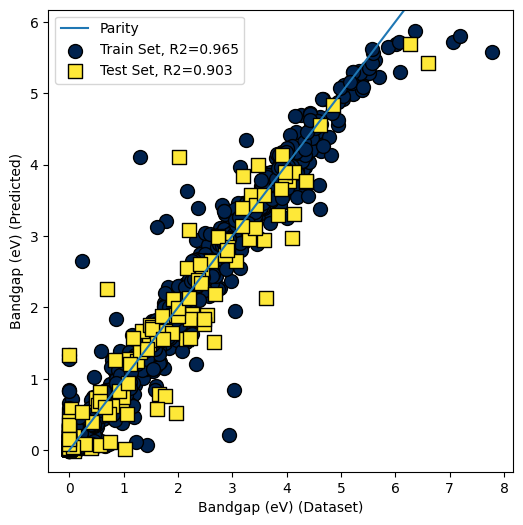

In [16]:
DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(train_y_true = train_y,
                                                                    train_y_pred = best_reg.predict(train_x),
                                                                    test_y_true = test_y,
                                                                    test_y_pred = best_reg.predict(test_x),
                                                                    axis_label = "Bandgap (eV)",
                                                                    filename = "xgboost_2dm_bandgap_parity.jpeg")

In [17]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=test_y, y_pred=best_reg.predict(test_x))
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=train_y, y_pred=best_reg.predict(train_x))
    print(key,np.round(value,4))

Test Set Error Metrics
MaxError 2.0865
MAE 0.2943
MSE 0.2229
RMSE 0.4721
MAPE 138885427083235.56
R2 0.9032

Training Set Error Metrics
MaxError 2.8088
MAE 0.1638
MSE 0.084
RMSE 0.2898
MAPE 96663842153985.1
R2 0.9645


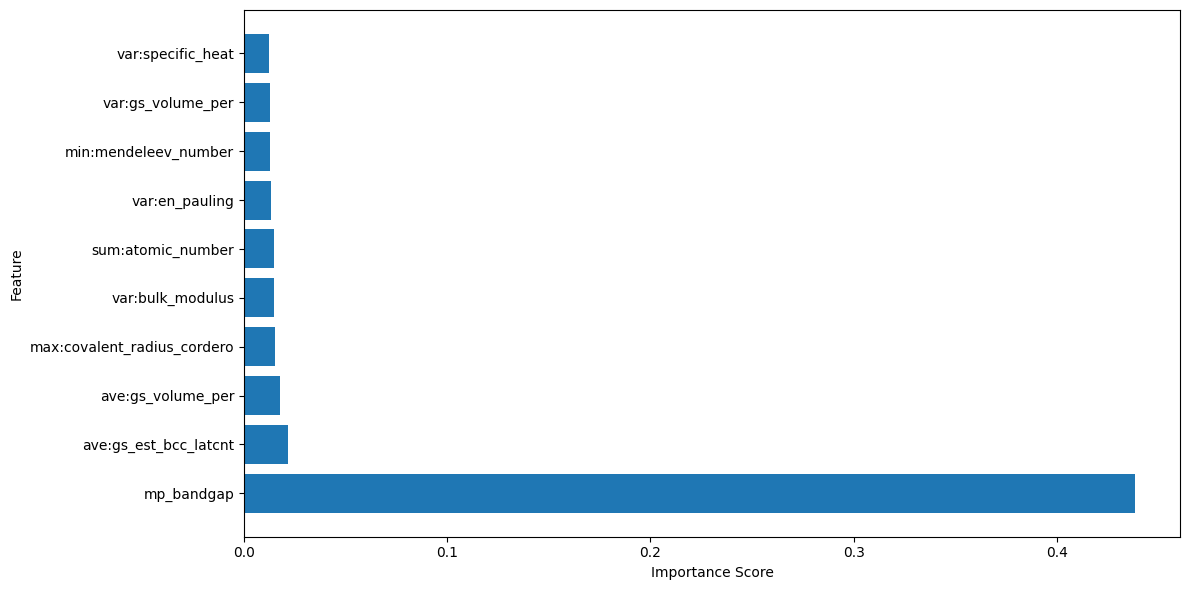

In [31]:
n_importances = 10
importances = list(zip(best_reg[1].feature_importances_, descriptors))

sorted_importances = list(sorted(importances, key=lambda i: -i[0]))

old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (2*old_figsize[0], old_figsize[1])

plt.barh(range(n_importances), [imp[0] for imp in sorted_importances[:n_importances]])
plt.yticks(range(n_importances), [imp[1] for imp in sorted_importances[:n_importances]])
plt.ylabel("Feature")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("xgboost_2dm_bandgap_importances.pdf")
plt.rcParams["figure.figsize"] = old_figsize

Finally, for some book-keeping purposes, we'll go ahead and save the predictions from the XGBoost model, along with the importance scores from the above plot. Also, we'll go ahead and pickle the XGBoost pipeline.

In [35]:
train_preds = train[target_column]
train_preds['TrainTest Status'] = ['Training Set'] * len(train_preds)
train_preds['Prediction'] = best_reg.predict(train_x)

test_preds = test[target_column]
test_preds['TrainTest Status'] = ['Test Set'] * len(test_preds)
test_preds['Prediction'] = best_reg.predict(test_x)

xgb_predictions = train_preds.append(test_preds)
xgb_predictions.to_csv("xgboost_2dm_bandgap_predictions.csv")

In [36]:
with open("xgboost_2dm_bandgap_importances.csv", "w") as outp:
    outp.write("Descriptor,XGB_Importance\n")
    for importance, descriptor in sorted_importances:
        outp.write(f"{descriptor},{importance}\n")

In [37]:
with open("xgboost_pipeline.pkl", "wb") as outp:
    pickle.dump(best_reg, outp)

# TPOT

TPOT is an AutoML solution that uses a genetic algorithm to create an ML pipeline to address a given problem. Here, we'll run a population of 100 models over 10 generations, taking the 10-fold cross-validated RMSE as the fitness metric.

We'll also go ahead and save a parity plot of the TPOT model.

In [11]:
# tpot_model = tpot.TPOTRegressor(
#     generations=100,
#     population_size=100,
#     max_eval_time_mins=10 / 60,
#     cv=10,
#     verbosity=2,
#     scoring="neg_root_mean_squared_error",
#     config_dict=tpot.config.regressor_config_dict,
#     n_jobs=-1,
#     random_state=1234
# )

# tpot_model.fit(train_x, train_y.ravel())

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.91918931106907

Generation 2 - Current best internal CV score: -0.91918931106907


TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.2, min_samples_leaf=9, min_samples_split=15, n_estimators=100)


TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

In [ ]:
tpot_rr_coefs = zip(tpot_model.fitted_pipeline_[1].coef_, descriptors)
sorted_tpot_rr_coefs = list(sorted(tpot_rr_coefs, key=lambda i: -abs(i[0])))

old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (2*old_figsize[0], old_figsize[1])
print(sorted_tpot_rr_coefs)

plt.barh(range(n_importances), [imp[0] for imp in sorted_tpot_rr_coefs[:n_importances]])
plt.yticks(range(n_importances), [imp[1] for imp in sorted_tpot_rr_coefs[:n_importances]])
plt.ylabel("Feature")
plt.xlabel("Elastic Net Feature Coefficient")
plt.tight_layout()
plt.savefig("tpot_2dm_elasticnet_coefficients.jpeg")
plt.show()
plt.close()

plt.rcParams['figure.figsize'] = old_figsize

In [ ]:
DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(train_y_true = train_y,
                                                                    train_y_pred = tpot_model.predict(train_x),
                                                                    test_y_true = test_y,
                                                                    test_y_pred = tpot_model.predict(test_x),
                                                                    axis_label = "Bandgap (eV))",
                                                                    filename = "tpot_2dm_bandgap_parity.jpeg")

In [ ]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=test_y, y_pred=tpot_model.predict(test_x))
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=train_y, y_pred=tpot_model.predict(train_x))
    print(key,np.round(value,4))

Finally, we'll go ahead and back up those predictions to the disk (this way, we don't need to re-run this again just to get those), and we'll pickle the TPOT model. We'll also have TPOT auto-generate some Python code to re-train itself.

In [ ]:
train_preds = train[target_column]
train_preds['TrainTest Status'] = ['Training Set'] * len(train_preds)
train_preds['Prediction'] = tpot_model.predict(train_x)

test_preds = test[target_column]
test_preds['TrainTest Status'] = ['Test Set'] * len(test_preds)
test_preds['Prediction'] = tpot_model.predict(test_x)

tpot_predictions = train_preds.append(test_preds)
tpot_predictions.to_csv("tpot_2dm_bandgap_predictions.csv")

At this point, a SISSO model was run. The models are stored below.

The model forms are from the SISSO logfiles. Coefficients have been copied directly from the SISSO outputs here.

In [ ]:
tpot_model.export('tpot_autogenerated_pipeline.py')
with open("tpot_pipeline.pkl", "wb") as outp:
    pickle.dump(tpot_model.fitted_pipeline_, outp)

In [13]:
import numpy as np

generations = np.loadtxt("tpot/generations.dat")

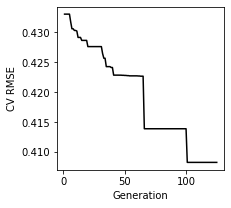

In [15]:
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["font.size"] = 10

plt.plot(generations[:, 0], generations[:, 1], 'k-', lw=1.50)

plt.xlabel(f"Generation")
plt.ylabel(f"CV RMSE")
plt.savefig("bandgap_convergence.pdf")
plt.show()
plt.close()

# Roost

[Roost](https://github.com/CompRhys/roost) is a neural network approach to predicting material properties as a function of their composition. Although we only have 144 data-points here, we can at least try for a good model.

Since the model only requires material IDs, the composition, and the property of interest, we'll save a CSV containing those properties.

In [ ]:
roost_dir = "./roost"
os.makedirs(roost_dir, exist_ok=True)
roost_data_train = train[['formula'] + target_column]
roost_data_test = test[['formula'] + target_column]

roost_data_train.to_csv(os.path.join(roost_dir, 'roost_train.csv'), index_label='material_id')
roost_data_test.to_csv(os.path.join(roost_dir, 'roost_test.csv'), index_label='material_id')

At this point, Roost models were run. Logs can be found in the Roost directory, along with the resultant predictions.

In [ ]:
roost_train_results = pd.read_csv("roost/roost_train_predictions.csv", index_col="material_id")
roost_test_results  = pd.read_csv("roost/roost_test_predictions.csv", index_col="material_id")

In [ ]:
DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(train_y_true = roost_train_results['bandgap_target'],
                                                                    train_y_pred =  roost_train_results['bandgap_pred_n0'],
                                                                    test_y_true = roost_test_results['bandgap_target'],
                                                                    test_y_pred = roost_test_results['bandgap_pred_n0'],
                                                                    axis_label = "Bandgap (eV)",
                                                                    filename = "roost_2dm_bandgap_parity.jpeg")

In [ ]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=roost_test_results['bandgap_target'], y_pred=roost_test_results['bandgap_pred_n0'])
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=roost_train_results['bandgap_target'], y_pred=roost_train_results['bandgap_pred_n0'])
    print(key,np.round(value,4))

# SISSO

SISSO is a symbolic regression technique focused on creating interpretable machine learning models. 

Due to the exponential computational cost of running a SISSO model as the number of features and rungs increases, we need to restrict the feature space. To do that, we'll use LASSO-based feature selection (essentially we can look at how quickly LASSO extinguishes a variable to get an idea of its importance). 

# SISSO++ ALL

In [11]:
from sissopp.py_interface import read_csv
from sissopp import FeatureSpace, SISSORegressor

from sissopp.postprocess.feature_space_analysis import get_prevelance_of_primary_features
from sissopp.postprocess.load_models import create_model_csv, load_model

from time import time
from pathlib import Path
import os

In [12]:
cwd = Path.cwd()

In [13]:
# Rename columns to include units
new_col_names = ["2dm_id (unitless)","Total Angles (n_angles)","Total Atoms (n_atoms)","Total Bonds (n_bonds)","alkaine_earth (n_atoms)","alkaine_earth-alkaine_earth (n_bonds)","alkaine_earth-alkaine_earth-alkaine_earth (n_angles)","alkaine_earth-chalcogen (n_bonds)","alkaine_earth-chalcogen-alkaine_earth (n_angles)","alkaine_earth-chalcogen-alkaline (n_angles)","alkaine_earth-chalcogen-chalcogen (n_angles)","alkaine_earth-chalcogen-early_transition (n_angles)","alkaine_earth-chalcogen-halide (n_angles)","alkaine_earth-chalcogen-late_transition (n_angles)","alkaine_earth-chalcogen-pnictogen (n_angles)","alkaine_earth-chalcogen-tetrel (n_angles)","alkaine_earth-chalcogen-triel (n_angles)","alkaine_earth-early_transition (n_bonds)","alkaine_earth-early_transition-alkaine_earth (n_angles)","alkaine_earth-early_transition-chalcogen (n_angles)","alkaine_earth-early_transition-early_transition (n_angles)","alkaine_earth-early_transition-tetrel (n_angles)","alkaine_earth-f_block (n_bonds)","alkaine_earth-f_block-alkaine_earth (n_angles)","alkaine_earth-f_block-f_block (n_angles)","alkaine_earth-halide (n_bonds)","alkaine_earth-halide-alkaine_earth (n_angles)","alkaine_earth-halide-early_transition (n_angles)","alkaine_earth-halide-tetrel (n_angles)","alkaine_earth-late_transition (n_bonds)","alkaine_earth-late_transition-alkaine_earth (n_angles)","alkaine_earth-late_transition-chalcogen (n_angles)","alkaine_earth-late_transition-late_transition (n_angles)","alkaine_earth-late_transition-tetrel (n_angles)","alkaine_earth-pnictogen (n_bonds)","alkaine_earth-pnictogen-alkaine_earth (n_angles)","alkaine_earth-pnictogen-chalcogen (n_angles)","alkaine_earth-pnictogen-pnictogen (n_angles)","alkaine_earth-pnictogen-tetrel (n_angles)","alkaine_earth-tetrel (n_bonds)","alkaine_earth-tetrel-alkaine_earth (n_angles)","alkaine_earth-tetrel-chalcogen (n_angles)","alkaine_earth-tetrel-tetrel (n_angles)","alkaline (n_atoms)","alkaline-alkaline (n_bonds)","alkaline-alkaline-alkaline (n_angles)","alkaline-alkaline-chalcogen (n_angles)","alkaline-chalcogen (n_bonds)","alkaline-chalcogen-alkaine_earth (n_angles)","alkaline-chalcogen-alkaline (n_angles)","alkaline-chalcogen-chalcogen (n_angles)","alkaline-chalcogen-early_transition (n_angles)","alkaline-chalcogen-f_block (n_angles)","alkaline-chalcogen-halide (n_angles)","alkaline-chalcogen-late_transition (n_angles)","alkaline-chalcogen-pnictogen (n_angles)","alkaline-chalcogen-tetrel (n_angles)","alkaline-early_transition (n_bonds)","alkaline-early_transition-alkaline (n_angles)","alkaline-early_transition-chalcogen (n_angles)","alkaline-early_transition-early_transition (n_angles)","alkaline-early_transition-halide (n_angles)","alkaline-f_block (n_bonds)","alkaline-f_block-alkaline (n_angles)","alkaline-f_block-halide (n_angles)","alkaline-halide (n_bonds)","alkaline-halide-early_transition (n_angles)","alkaline-halide-late_transition (n_angles)","alkaline-late_transition (n_bonds)","alkaline-late_transition-alkaline (n_angles)","alkaline-late_transition-chalcogen (n_angles)","alkaline-late_transition-halide (n_angles)","alkaline-late_transition-late_transition (n_angles)","alkaline-late_transition-pnictogen (n_angles)","alkaline-pnictogen (n_bonds)","alkaline-pnictogen-alkaine_earth (n_angles)","alkaline-pnictogen-alkaline (n_angles)","alkaline-pnictogen-chalcogen (n_angles)","alkaline-pnictogen-tetrel (n_angles)","alkaline-tetrel (n_bonds)","alkaline-tetrel-alkaline (n_angles)","alkaline-tetrel-chalcogen (n_angles)","alkaline-tetrel-tetrel (n_angles)","alkaline-triel (n_bonds)","alkaline-triel-alkaline (n_angles)","alkaline-triel-triel (n_angles)","atoms_object (unitless)","ave:Polarizability (AA_polar)","ave:atomic_number","ave:atomic_radius (pm)","ave:atomic_radius_rahm (pm)","ave:atomic_volume (cm^3 / mol)","ave:atomic_weight (Da)","ave:boiling_point (K)","ave:bulk_modulus (GPa)","ave:c6_gb (Eh / a0^6)","ave:covalent_radius_cordero (pm)","ave:covalent_radius_pyykko (pm)","ave:covalent_radius_pyykko_double (pm)","ave:covalent_radius_pyykko_triple (pm)","ave:covalent_radius_slater (pm)","ave:density (g / cm^3)","ave:dipole_polarizability (AA_polar^3)","ave:electron_affinity (eV)","ave:electron_negativity (Pauling)","ave:en_allen (eV)","ave:en_ghosh (ghosh)","ave:en_pauling (Pauling)","ave:evaporation_heat (KJ / mol)","ave:first_ion_en (eV)","ave:fusion_enthalpy (KJ / mol)","ave:gs_bandgap (eV)","ave:gs_energy (eV)","ave:gs_est_bcc_latcnt (AA)","ave:gs_est_fcc_latcnt (AA)","ave:gs_mag_moment (mu_B)","ave:gs_volume_per (cm^3 / mol)","ave:heat_capacity_mass (J / g / K)","ave:heat_capacity_molar (J / mol / K)","ave:heat_of_formation (KJ / mol)","ave:hhi_p","ave:hhi_r","ave:icsd_volume (cm^3 / mol)","ave:lattice_constant (AA)","ave:melting_point (K)","ave:mendeleev_number","ave:molar_volume (cm^3)","ave:num_d_unfilled","ave:num_d_valence","ave:num_f_unfilled","ave:num_f_valence","ave:num_p_unfilled","ave:num_p_valence","ave:num_s_unfilled","ave:num_s_valence","ave:num_unfilled","ave:num_valance","ave:period","ave:sound_velocity (m / s)","ave:specific_heat (J / g / K)","ave:thermal_conductivity (W / m / K)","ave:vdw_radius (pm)","ave:vdw_radius_alvarez (pm)","ave:vdw_radius_mm3 (pm)","ave:vdw_radius_uff (pm)","average_cn","bandgap (eV)","bond_angle_average (rad)","bond_length_average (AA)","chalcogen (n_atoms)","chalcogen-alkaine_earth-chalcogen (n_angles)","chalcogen-alkaline-chalcogen (n_angles)","chalcogen-chalcogen (n_bonds)","chalcogen-chalcogen-alkaline (n_angles)","chalcogen-chalcogen-chalcogen (n_angles)","chalcogen-chalcogen-early_transition (n_angles)","chalcogen-chalcogen-halide (n_angles)","chalcogen-chalcogen-late_transition (n_angles)","chalcogen-chalcogen-pnictogen (n_angles)","chalcogen-chalcogen-tetrel (n_angles)","chalcogen-early_transition (n_bonds)","chalcogen-early_transition-chalcogen (n_angles)","chalcogen-early_transition-early_transition (n_angles)","chalcogen-early_transition-halide (n_angles)","chalcogen-early_transition-late_transition (n_angles)","chalcogen-early_transition-pnictogen (n_angles)","chalcogen-f_block (n_bonds)","chalcogen-f_block-chalcogen (n_angles)","chalcogen-f_block-halide (n_angles)","chalcogen-f_block-pnictogen (n_angles)","chalcogen-halide (n_bonds)","chalcogen-halide-chalcogen (n_angles)","chalcogen-halide-early_transition (n_angles)","chalcogen-halide-halide (n_angles)","chalcogen-late_transition (n_bonds)","chalcogen-late_transition-chalcogen (n_angles)","chalcogen-late_transition-early_transition (n_angles)","chalcogen-late_transition-halide (n_angles)","chalcogen-late_transition-late_transition (n_angles)","chalcogen-late_transition-pnictogen (n_angles)","chalcogen-late_transition-tetrel (n_angles)","chalcogen-noble_gas (n_bonds)","chalcogen-noble_gas-chalcogen (n_angles)","chalcogen-noble_gas-halide (n_angles)","chalcogen-pnictogen (n_bonds)","chalcogen-pnictogen-chalcogen (n_angles)","chalcogen-pnictogen-halide (n_angles)","chalcogen-pnictogen-pnictogen (n_angles)","chalcogen-post_uranium (n_bonds)","chalcogen-post_uranium-chalcogen (n_angles)","chalcogen-post_uranium-halide (n_angles)","chalcogen-tetrel (n_bonds)","chalcogen-tetrel-chalcogen (n_angles)","chalcogen-tetrel-halide (n_angles)","chalcogen-tetrel-pnictogen (n_angles)","chalcogen-triel (n_bonds)","chalcogen-triel-chalcogen (n_angles)","chalcogen-triel-halide (n_angles)","decomposition_energy (eV/atom)","discovery_process (Unitless)","early_transition (n_atoms)","early_transition-alkaine_earth-chalcogen (n_angles)","early_transition-alkaine_earth-early_transition (n_angles)","early_transition-alkaline-chalcogen (n_angles)","early_transition-alkaline-early_transition (n_angles)","early_transition-chalcogen-alkaine_earth (n_angles)","early_transition-chalcogen-alkaline (n_angles)","early_transition-chalcogen-chalcogen (n_angles)","early_transition-chalcogen-early_transition (n_angles)","early_transition-chalcogen-halide (n_angles)","early_transition-chalcogen-late_transition (n_angles)","early_transition-chalcogen-pnictogen (n_angles)","early_transition-chalcogen-tetrel (n_angles)","early_transition-chalcogen-triel (n_angles)","early_transition-early_transition (n_bonds)","early_transition-early_transition-alkaine_earth (n_angles)","early_transition-early_transition-alkaline (n_angles)","early_transition-early_transition-chalcogen (n_angles)","early_transition-early_transition-early_transition (n_angles)","early_transition-early_transition-halide (n_angles)","early_transition-early_transition-late_transition (n_angles)","early_transition-early_transition-pnictogen (n_angles)","early_transition-early_transition-tetrel (n_angles)","early_transition-early_transition-triel (n_angles)","early_transition-f_block (n_bonds)","early_transition-f_block-chalcogen (n_angles)","early_transition-f_block-early_transition (n_angles)","early_transition-f_block-pnictogen (n_angles)","early_transition-halide (n_bonds)","early_transition-halide-chalcogen (n_angles)","early_transition-halide-early_transition (n_angles)","early_transition-halide-halide (n_angles)","early_transition-halide-late_transition (n_angles)","early_transition-halide-pnictogen (n_angles)","early_transition-halide-tetrel (n_angles)","early_transition-late_transition (n_bonds)","early_transition-late_transition-chalcogen (n_angles)","early_transition-late_transition-early_transition (n_angles)","early_transition-late_transition-halide (n_angles)","early_transition-late_transition-late_transition (n_angles)","early_transition-late_transition-pnictogen (n_angles)","early_transition-late_transition-tetrel (n_angles)","early_transition-late_transition-triel (n_angles)","early_transition-pnictogen (n_bonds)","early_transition-pnictogen-alkaline (n_angles)","early_transition-pnictogen-chalcogen (n_angles)","early_transition-pnictogen-early_transition (n_angles)","early_transition-pnictogen-halide (n_angles)","early_transition-pnictogen-pnictogen (n_angles)","early_transition-tetrel (n_bonds)","early_transition-tetrel-chalcogen (n_angles)","early_transition-tetrel-early_transition (n_angles)","early_transition-tetrel-late_transition (n_angles)","early_transition-tetrel-tetrel (n_angles)","early_transition-tetrel-triel (n_angles)","early_transition-triel (n_bonds)","early_transition-triel-chalcogen (n_angles)","early_transition-triel-early_transition (n_angles)","early_transition-triel-late_transition (n_angles)","early_transition-triel-tetrel (n_angles)","early_transition-triel-triel (n_angles)","energy_per_atom (eV)","energy_vdw_per_atom (eV/atom)","ewald_energy_per_atom (eV / atom)","exfoliation_energy_per_atom (eV/atom)","f_block (n_atoms)","f_block-alkaine_earth-f_block (n_angles)","f_block-alkaline-f_block (n_angles)","f_block-chalcogen-alkaline (n_angles)","f_block-chalcogen-chalcogen (n_angles)","f_block-chalcogen-early_transition (n_angles)","f_block-chalcogen-f_block (n_angles)","f_block-chalcogen-halide (n_angles)","f_block-chalcogen-late_transition (n_angles)","f_block-chalcogen-pnictogen (n_angles)","f_block-chalcogen-tetrel (n_angles)","f_block-chalcogen-triel (n_angles)","f_block-early_transition-chalcogen (n_angles)","f_block-early_transition-early_transition (n_angles)","f_block-early_transition-f_block (n_angles)","f_block-early_transition-pnictogen (n_angles)","f_block-f_block (n_bonds)","f_block-f_block-alkaine_earth (n_angles)","f_block-f_block-alkaline (n_angles)","f_block-f_block-chalcogen (n_angles)","f_block-f_block-early_transition (n_angles)","f_block-f_block-f_block (n_angles)","f_block-f_block-halide (n_angles)","f_block-f_block-late_transition (n_angles)","f_block-f_block-pnictogen (n_angles)","f_block-f_block-tetrel (n_angles)","f_block-f_block-triel (n_angles)","f_block-halide (n_bonds)","f_block-halide-alkaine_earth (n_angles)","f_block-halide-chalcogen (n_angles)","f_block-halide-f_block (n_angles)","f_block-halide-halide (n_angles)","f_block-halide-tetrel (n_angles)","f_block-halide-triel (n_angles)","f_block-late_transition (n_bonds)","f_block-late_transition-alkaine_earth (n_angles)","f_block-late_transition-chalcogen (n_angles)","f_block-late_transition-f_block (n_angles)","f_block-late_transition-late_transition (n_angles)","f_block-late_transition-pnictogen (n_angles)","f_block-late_transition-tetrel (n_angles)","f_block-late_transition-triel (n_angles)","f_block-pnictogen (n_bonds)","f_block-pnictogen-chalcogen (n_angles)","f_block-pnictogen-early_transition (n_angles)","f_block-pnictogen-f_block (n_angles)","f_block-pnictogen-late_transition (n_angles)","f_block-pnictogen-pnictogen (n_angles)","f_block-tetrel (n_bonds)","f_block-tetrel-chalcogen (n_angles)","f_block-tetrel-f_block (n_angles)","f_block-tetrel-late_transition (n_angles)","f_block-tetrel-tetrel (n_angles)","f_block-tetrel-triel (n_angles)","f_block-triel (n_bonds)","f_block-triel-f_block (n_angles)","f_block-triel-late_transition (n_angles)","f_block-triel-tetrel (n_angles)","f_block-triel-triel (n_angles)","formula","global_instability (instable)","halide (n_atoms)","halide-alkaine_earth-chalcogen (n_angles)","halide-alkaine_earth-halide (n_angles)","halide-alkaline-halide (n_angles)","halide-chalcogen-chalcogen (n_angles)","halide-chalcogen-halide (n_angles)","halide-early_transition-chalcogen (n_angles)","halide-early_transition-halide (n_angles)","halide-early_transition-pnictogen (n_angles)","halide-f_block-chalcogen (n_angles)","halide-f_block-halide (n_angles)","halide-f_block-pnictogen (n_angles)","halide-halide (n_bonds)","halide-halide-chalcogen (n_angles)","halide-halide-halide (n_angles)","halide-halide-pnictogen (n_angles)","halide-late_transition (n_bonds)","halide-late_transition-chalcogen (n_angles)","halide-late_transition-halide (n_angles)","halide-late_transition-pnictogen (n_angles)","halide-noble_gas (n_bonds)","halide-noble_gas-halide (n_angles)","halide-pnictogen (n_bonds)","halide-pnictogen-chalcogen (n_angles)","halide-pnictogen-halide (n_angles)","halide-post_uranium (n_bonds)","halide-post_uranium-chalcogen (n_angles)","halide-post_uranium-halide (n_angles)","halide-tetrel (n_bonds)","halide-tetrel-chalcogen (n_angles)","halide-tetrel-halide (n_angles)","halide-triel (n_bonds)","halide-triel-chalcogen (n_angles)","halide-triel-halide (n_angles)","is_bandgap_direct (unitless)","is_hubbard (unitless)","is_metal (unitless)","late_transition (n_atoms)","late_transition-alkaine_earth-chalcogen (n_angles)","late_transition-alkaine_earth-late_transition (n_angles)","late_transition-alkaline-chalcogen (n_angles)","late_transition-alkaline-halide (n_angles)","late_transition-alkaline-late_transition (n_angles)","late_transition-alkaline-triel (n_angles)","late_transition-chalcogen-alkaline (n_angles)","late_transition-chalcogen-chalcogen (n_angles)","late_transition-chalcogen-early_transition (n_angles)","late_transition-chalcogen-halide (n_angles)","late_transition-chalcogen-late_transition (n_angles)","late_transition-chalcogen-pnictogen (n_angles)","late_transition-chalcogen-tetrel (n_angles)","late_transition-chalcogen-triel (n_angles)","late_transition-early_transition-chalcogen (n_angles)","late_transition-early_transition-early_transition (n_angles)","late_transition-early_transition-halide (n_angles)","late_transition-early_transition-late_transition (n_angles)","late_transition-early_transition-pnictogen (n_angles)","late_transition-early_transition-tetrel (n_angles)","late_transition-f_block-chalcogen (n_angles)","late_transition-f_block-late_transition (n_angles)","late_transition-f_block-pnictogen (n_angles)","late_transition-f_block-tetrel (n_angles)","late_transition-halide-chalcogen (n_angles)","late_transition-halide-early_transition (n_angles)","late_transition-halide-late_transition (n_angles)","late_transition-halide-noble_gas (n_angles)","late_transition-halide-pnictogen (n_angles)","late_transition-late_transition (n_bonds)","late_transition-late_transition-alkaline (n_angles)","late_transition-late_transition-chalcogen (n_angles)","late_transition-late_transition-early_transition (n_angles)","late_transition-late_transition-halide (n_angles)","late_transition-late_transition-late_transition (n_angles)","late_transition-late_transition-pnictogen (n_angles)","late_transition-late_transition-tetrel (n_angles)","late_transition-late_transition-triel (n_angles)","late_transition-pnictogen (n_bonds)","late_transition-pnictogen-alkaline (n_angles)","late_transition-pnictogen-chalcogen (n_angles)","late_transition-pnictogen-early_transition (n_angles)","late_transition-pnictogen-halide (n_angles)","late_transition-pnictogen-late_transition (n_angles)","late_transition-pnictogen-pnictogen (n_angles)","late_transition-pnictogen-tetrel (n_angles)","late_transition-pnictogen-triel (n_angles)","late_transition-tetrel (n_bonds)","late_transition-tetrel-chalcogen (n_angles)","late_transition-tetrel-late_transition (n_angles)","late_transition-tetrel-pnictogen (n_angles)","late_transition-tetrel-tetrel (n_angles)","late_transition-triel (n_bonds)","late_transition-triel-alkaline (n_angles)","late_transition-triel-chalcogen (n_angles)","late_transition-triel-halide (n_angles)","late_transition-triel-late_transition (n_angles)","late_transition-triel-pnictogen (n_angles)","late_transition-triel-triel (n_angles)","max:Polarizability (AA_polar)","max:atomic_number","max:atomic_radius (pm)","max:atomic_radius_rahm (pm)","max:atomic_volume (cm^3 / mol)","max:atomic_weight (Da)","max:boiling_point (K)","max:bulk_modulus (GPa)","max:c6_gb (Eh / a0^6)","max:covalent_radius_cordero (pm)","max:covalent_radius_pyykko (pm)","max:covalent_radius_pyykko_double (pm)","max:covalent_radius_pyykko_triple (pm)","max:covalent_radius_slater (pm)","max:density (g / cm^3)","max:dipole_polarizability (AA_polar^3)","max:electron_affinity (eV)","max:electron_negativity (Pauling)","max:en_allen (eV)","max:en_ghosh (ghosh)","max:en_pauling (Pauling)","max:evaporation_heat (KJ / mol)","max:first_ion_en (eV)","max:fusion_enthalpy (KJ / mol)","max:gs_bandgap (eV)","max:gs_energy (eV)","max:gs_est_bcc_latcnt (AA)","max:gs_est_fcc_latcnt (AA)","max:gs_mag_moment (mu_B)","max:gs_volume_per (cm^3 / mol)","max:heat_capacity_mass (J / g / K)","max:heat_capacity_molar (J / mol / K)","max:heat_of_formation (KJ / mol)","max:hhi_p","max:hhi_r","max:icsd_volume (cm^3 / mol)","max:lattice_constant (AA)","max:melting_point (K)","max:mendeleev_number","max:molar_volume (cm^3)","max:num_d_unfilled","max:num_d_valence","max:num_f_unfilled","max:num_f_valence","max:num_p_unfilled","max:num_p_valence","max:num_s_unfilled","max:num_s_valence","max:num_unfilled","max:num_valance","max:period","max:sound_velocity (m / s)","max:specific_heat (J / g / K)","max:thermal_conductivity (W / m / K)","max:vdw_radius (pm)","max:vdw_radius_alvarez (pm)","max:vdw_radius_mm3 (pm)","max:vdw_radius_uff (pm)","min:Polarizability (AA_polar)","min:atomic_number","min:atomic_radius (pm)","min:atomic_radius_rahm (pm)","min:atomic_volume (cm^3 / mol)","min:atomic_weight (Da)","min:boiling_point (K)","min:bulk_modulus (GPa)","min:c6_gb (Eh / a0^6)","min:covalent_radius_cordero (pm)","min:covalent_radius_pyykko (pm)","min:covalent_radius_pyykko_double (pm)","min:covalent_radius_pyykko_triple (pm)","min:covalent_radius_slater (pm)","min:density (g / cm^3)","min:dipole_polarizability (AA_polar^3)","min:electron_affinity (eV)","min:electron_negativity (Pauling)","min:en_allen (eV)","min:en_ghosh (ghosh)","min:en_pauling (Pauling)","min:evaporation_heat (KJ / mol)","min:first_ion_en (eV)","min:fusion_enthalpy (KJ / mol)","min:gs_bandgap (eV)","min:gs_energy (eV)","min:gs_est_bcc_latcnt (AA)","min:gs_est_fcc_latcnt (AA)","min:gs_mag_moment (mu_B)","min:gs_volume_per (cm^3 / mol)","min:heat_capacity_mass (J / g / K)","min:heat_capacity_molar (J / mol / K)","min:heat_of_formation (KJ / mol)","min:hhi_p","min:hhi_r","min:icsd_volume (cm^3 / mol)","min:lattice_constant (AA)","min:melting_point (K)","min:mendeleev_number","min:molar_volume (cm^3)","min:num_d_unfilled","min:num_d_valence","min:num_f_unfilled","min:num_f_valence","min:num_p_unfilled","min:num_p_valence","min:num_s_unfilled","min:num_s_valence","min:num_unfilled","min:num_valance","min:period","min:sound_velocity (m / s)","min:specific_heat (J / g / K)","min:thermal_conductivity (W / m / K)","min:vdw_radius (pm)","min:vdw_radius_alvarez (pm)","min:vdw_radius_mm3 (pm)","min:vdw_radius_uff (pm)","n_symmetry_ops","noble_gas (n_atoms)","noble_gas-chalcogen-noble_gas (n_angles)","perimeter_area_ratio (AA^-1)","pnictogen (n_atoms)","pnictogen-alkaine_earth-chalcogen (n_angles)","pnictogen-alkaine_earth-pnictogen (n_angles)","pnictogen-alkaline-pnictogen (n_angles)","pnictogen-chalcogen-alkaline (n_angles)","pnictogen-chalcogen-chalcogen (n_angles)","pnictogen-chalcogen-early_transition (n_angles)","pnictogen-chalcogen-late_transition (n_angles)","pnictogen-chalcogen-pnictogen (n_angles)","pnictogen-chalcogen-tetrel (n_angles)","pnictogen-chalcogen-triel (n_angles)","pnictogen-early_transition-chalcogen (n_angles)","pnictogen-early_transition-early_transition (n_angles)","pnictogen-early_transition-halide (n_angles)","pnictogen-early_transition-pnictogen (n_angles)","pnictogen-f_block-chalcogen (n_angles)","pnictogen-f_block-halide (n_angles)","pnictogen-f_block-pnictogen (n_angles)","pnictogen-halide-halide (n_angles)","pnictogen-halide-late_transition (n_angles)","pnictogen-halide-pnictogen (n_angles)","pnictogen-late_transition-chalcogen (n_angles)","pnictogen-late_transition-halide (n_angles)","pnictogen-late_transition-late_transition (n_angles)","pnictogen-late_transition-pnictogen (n_angles)","pnictogen-pnictogen (n_bonds)","pnictogen-pnictogen-chalcogen (n_angles)","pnictogen-pnictogen-early_transition (n_angles)","pnictogen-pnictogen-halide (n_angles)","pnictogen-pnictogen-late_transition (n_angles)","pnictogen-pnictogen-pnictogen (n_angles)","pnictogen-pnictogen-tetrel (n_angles)","pnictogen-pnictogen-triel (n_angles)","pnictogen-tetrel (n_bonds)","pnictogen-tetrel-chalcogen (n_angles)","pnictogen-tetrel-pnictogen (n_angles)","pnictogen-tetrel-tetrel (n_angles)","pnictogen-triel (n_bonds)","pnictogen-triel-chalcogen (n_angles)","pnictogen-triel-halide (n_angles)","pnictogen-triel-pnictogen (n_angles)","pnictogen-triel-triel (n_angles)","post_uranium (n_atoms)","post_uranium-chalcogen-chalcogen (n_angles)","post_uranium-chalcogen-post_uranium (n_angles)","post_uranium-halide-post_uranium (n_angles)","post_uranium-post_uranium (n_bonds)","post_uranium-post_uranium-chalcogen (n_angles)","post_uranium-post_uranium-post_uranium (n_angles)","potcars (unitless)","structural complexity per atom (comp / atom)","structural complexity per cell (comp / cell)","sum:Polarizability (AA_polar)","sum:atomic_number","sum:atomic_radius (pm)","sum:atomic_radius_rahm (pm)","sum:atomic_volume (cm^3 / mol)","sum:atomic_weight (Da)","sum:boiling_point (K)","sum:bulk_modulus (GPa)","sum:c6_gb (Eh / a0^6)","sum:covalent_radius_cordero (pm)","sum:covalent_radius_pyykko (pm)","sum:covalent_radius_pyykko_double (pm)","sum:covalent_radius_pyykko_triple (pm)","sum:covalent_radius_slater (pm)","sum:density (g / cm^3)","sum:dipole_polarizability (AA_polar^3)","sum:electron_affinity (eV)","sum:electron_negativity (Pauling)","sum:en_allen (eV)","sum:en_ghosh (ghosh)","sum:en_pauling (Pauling)","sum:evaporation_heat (KJ / mol)","sum:first_ion_en (eV)","sum:fusion_enthalpy (KJ / mol)","sum:gs_bandgap (eV)","sum:gs_energy (eV)","sum:gs_est_bcc_latcnt (AA)","sum:gs_est_fcc_latcnt (AA)","sum:gs_mag_moment (mu_B)","sum:gs_volume_per (cm^3 / mol)","sum:heat_capacity_mass (J / g / K)","sum:heat_capacity_molar (J / mol / K)","sum:heat_of_formation (KJ / mol)","sum:hhi_p","sum:hhi_r","sum:icsd_volume (cm^3 / mol)","sum:lattice_constant (AA)","sum:melting_point (K)","sum:mendeleev_number","sum:molar_volume (cm^3)","sum:num_d_unfilled","sum:num_d_valence","sum:num_f_unfilled","sum:num_f_valence","sum:num_p_unfilled","sum:num_p_valence","sum:num_s_unfilled","sum:num_s_valence","sum:num_unfilled","sum:num_valance","sum:period","sum:sound_velocity (m / s)","sum:specific_heat (J / g / K)","sum:thermal_conductivity (W / m / K)","sum:vdw_radius (pm)","sum:vdw_radius_alvarez (pm)","sum:vdw_radius_mm3 (pm)","sum:vdw_radius_uff (pm)","tetrel (n_atoms)","tetrel-alkaine_earth-chalcogen (n_angles)","tetrel-alkaine_earth-tetrel (n_angles)","tetrel-chalcogen-alkaline (n_angles)","tetrel-chalcogen-chalcogen (n_angles)","tetrel-chalcogen-early_transition (n_angles)","tetrel-chalcogen-halide (n_angles)","tetrel-chalcogen-late_transition (n_angles)","tetrel-chalcogen-pnictogen (n_angles)","tetrel-chalcogen-tetrel (n_angles)","tetrel-early_transition-chalcogen (n_angles)","tetrel-early_transition-halide (n_angles)","tetrel-early_transition-late_transition (n_angles)","tetrel-early_transition-tetrel (n_angles)","tetrel-f_block-chalcogen (n_angles)","tetrel-f_block-halide (n_angles)","tetrel-f_block-late_transition (n_angles)","tetrel-f_block-tetrel (n_angles)","tetrel-halide-halide (n_angles)","tetrel-halide-tetrel (n_angles)","tetrel-late_transition-chalcogen (n_angles)","tetrel-late_transition-halide (n_angles)","tetrel-late_transition-late_transition (n_angles)","tetrel-late_transition-pnictogen (n_angles)","tetrel-late_transition-tetrel (n_angles)","tetrel-pnictogen-alkaline (n_angles)","tetrel-pnictogen-chalcogen (n_angles)","tetrel-pnictogen-late_transition (n_angles)","tetrel-pnictogen-pnictogen (n_angles)","tetrel-pnictogen-tetrel (n_angles)","tetrel-pnictogen-triel (n_angles)","tetrel-tetrel (n_bonds)","tetrel-tetrel-alkaline (n_angles)","tetrel-tetrel-chalcogen (n_angles)","tetrel-tetrel-early_transition (n_angles)","tetrel-tetrel-halide (n_angles)","tetrel-tetrel-late_transition (n_angles)","tetrel-tetrel-pnictogen (n_angles)","tetrel-tetrel-tetrel (n_angles)","tetrel-tetrel-triel (n_angles)","tetrel-triel (n_bonds)","tetrel-triel-chalcogen (n_angles)","tetrel-triel-pnictogen (n_angles)","tetrel-triel-tetrel (n_angles)","total_magnetization (muB)","triel (n_atoms)","triel-chalcogen-alkaline (n_angles)","triel-chalcogen-chalcogen (n_angles)","triel-chalcogen-early_transition (n_angles)","triel-chalcogen-halide (n_angles)","triel-chalcogen-late_transition (n_angles)","triel-chalcogen-pnictogen (n_angles)","triel-chalcogen-tetrel (n_angles)","triel-chalcogen-triel (n_angles)","triel-early_transition-chalcogen (n_angles)","triel-early_transition-early_transition (n_angles)","triel-early_transition-halide (n_angles)","triel-early_transition-late_transition (n_angles)","triel-early_transition-tetrel (n_angles)","triel-early_transition-triel (n_angles)","triel-f_block-halide (n_angles)","triel-f_block-late_transition (n_angles)","triel-f_block-tetrel (n_angles)","triel-f_block-triel (n_angles)","triel-halide-chalcogen (n_angles)","triel-halide-early_transition (n_angles)","triel-halide-halide (n_angles)","triel-halide-late_transition (n_angles)","triel-halide-pnictogen (n_angles)","triel-halide-tetrel (n_angles)","triel-halide-triel (n_angles)","triel-late_transition-alkaline (n_angles)","triel-late_transition-chalcogen (n_angles)","triel-late_transition-halide (n_angles)","triel-late_transition-late_transition (n_angles)","triel-late_transition-pnictogen (n_angles)","triel-late_transition-tetrel (n_angles)","triel-late_transition-triel (n_angles)","triel-pnictogen-alkaline (n_angles)","triel-pnictogen-chalcogen (n_angles)","triel-pnictogen-pnictogen (n_angles)","triel-pnictogen-tetrel (n_angles)","triel-pnictogen-triel (n_angles)","triel-tetrel-chalcogen (n_angles)","triel-tetrel-pnictogen (n_angles)","triel-tetrel-tetrel (n_angles)","triel-tetrel-triel (n_angles)","triel-triel (n_bonds)","triel-triel-chalcogen (n_angles)","triel-triel-early_transition (n_angles)","triel-triel-halide (n_angles)","triel-triel-late_transition (n_angles)","triel-triel-pnictogen (n_angles)","triel-triel-tetrel (n_angles)","triel-triel-triel (n_angles)","var:Polarizability (AA_polar)","var:atomic_number","var:atomic_radius (pm)","var:atomic_radius_rahm (pm)","var:atomic_volume (cm^3 / mol)","var:atomic_weight (Da)","var:boiling_point (K)","var:bulk_modulus (GPa)","var:c6_gb (Eh / a0^6)","var:covalent_radius_cordero (pm)","var:covalent_radius_pyykko (pm)","var:covalent_radius_pyykko_double (pm)","var:covalent_radius_pyykko_triple (pm)","var:covalent_radius_slater (pm)","var:density (g / cm^3)","var:dipole_polarizability (AA_polar^3)","var:electron_affinity (eV)","var:electron_negativity (Pauling)","var:en_allen (eV)","var:en_ghosh (ghosh)","var:en_pauling (Pauling)","var:evaporation_heat (KJ / mol)","var:first_ion_en (eV)","var:fusion_enthalpy (KJ / mol)","var:gs_bandgap (eV)","var:gs_energy (eV)","var:gs_est_bcc_latcnt (AA)","var:gs_est_fcc_latcnt (AA)","var:gs_mag_moment (mu_B)","var:gs_volume_per (cm^3 / mol)","var:heat_capacity_mass (J / g / K)","var:heat_capacity_molar (J / mol / K)","var:heat_of_formation (KJ / mol)","var:hhi_p","var:hhi_r","var:icsd_volume (cm^3 / mol)","var:lattice_constant (AA)","var:melting_point (K)","var:mendeleev_number","var:molar_volume (cm^3)","var:num_d_unfilled","var:num_d_valence","var:num_f_unfilled","var:num_f_valence","var:num_p_unfilled","var:num_p_valence","var:num_s_unfilled","var:num_s_valence","var:num_unfilled","var:num_valance","var:period","var:sound_velocity (m / s)","var:specific_heat (J / g / K)","var:thermal_conductivity (W / m / K)","var:vdw_radius (pm)","var:vdw_radius_alvarez (pm)","var:vdw_radius_mm3 (pm)","var:vdw_radius_uff (pm)","mp_bandgap (eV)",]
col_remap = {}
for col, new_col in zip(train.columns, new_col_names):
    col_remap[col] = new_col

train_sisso = train.rename(columns=col_remap)
test_sisso = test.rename(columns=col_remap)

train_sisso.drop(["formula", "atoms_object (unitless)", "2dm_id (unitless)"], axis=1, inplace=True)
test_sisso.drop(["formula", "atoms_object (unitless)", "2dm_id (unitless)"], axis=1, inplace=True)

not_number = np.where((train_sisso.dtypes != np.int64) & (train_sisso.dtypes != np.float64))[0]
train_sisso.drop(train_sisso.columns[not_number], inplace=True, axis=1)
test_sisso.drop(test_sisso.columns[not_number], inplace=True, axis=1)

for col in train_sisso.columns:
    if(np.any(np.isnan(train_sisso[col])) or np.any(np.isnan(test_sisso[col]))):
        train_sisso.drop(col, inplace=True, axis=1)
        test_sisso.drop(col, inplace=True, axis=1)
    else:
        train_sisso[col] = train_sisso[col].astype(float)
        test_sisso[col] = test_sisso[col].astype(float)

In [14]:
def gen_fs_sr(max_rung=2, n_sis=1000, leave_out_inds=[], n_dim=1, n_res=10, cols="all"):
    inputs = read_csv(train_sisso, "bandgap", leave_out_inds=list(leave_out_inds), max_rung=max_rung, cols=cols)
    inputs.n_sis_select = n_sis
    inputs.allowed_ops = [
        "add",
        "sub",
        "mult",
        "div",
        "abs_diff",
        "inv",
        "abs",
        "cos",
        "sin",
        "exp",
        "neg_exp",
        "log",
        "sq",
        "sqrt",
        "cb",
        "cbrt",
        "six_pow",
    ]
    inputs.n_dim = n_dim
    inputs.n_residual = n_res
    fs = FeatureSpace(inputs)
    sr = SISSORegressor(inputs, fs)
    return fs, sr

In [15]:
r1_path = Path("sisso_update_mp/rung_1_prev_check/")
r1_path.mkdir(parents=True, exist_ok=True)
os.chdir(r1_path)

fs_init, sr_init = gen_fs_sr(max_rung=1, n_sis=10000)
fs_init.sis(sr_init.prop_train)
phi_0_in_phi_sel = get_prevelance_of_primary_features(fs_init.phi_selected, fs_init.phi0)
prevelance = sorted([(key, val) for key, val in phi_0_in_phi_sel.items()], key=lambda prev: prev[1] * -1)
cols = [col_remap[prev[0]] for prev in prevelance[:30]]

os.chdir(cwd)
print(cols)

Time to generate feat space: 1.45686 s
Projection time: 0.319854 s
Time to get best features on rank : 0.17028 s
Complete final combination/selection from all ranks: 0.0941024 s
['mp_bandgap (eV)', 'min:covalent_radius_slater (pm)', 'min:boiling_point (K)', 'min:c6_gb (Eh / a0^6)', 'min:covalent_radius_cordero (pm)', 'min:melting_point (K)', 'min:dipole_polarizability (AA_polar^3)', 'min:Polarizability (AA_polar)', 'min:covalent_radius_pyykko (pm)', 'ave:boiling_point (K)', 'ave:density (g / cm^3)', 'min:period', 'ave:covalent_radius_slater (pm)', 'ave:covalent_radius_cordero (pm)', 'ave:melting_point (K)', 'ave:covalent_radius_pyykko (pm)', 'ave:period', 'max:en_allen (eV)', 'min:vdw_radius_alvarez (pm)', 'min:vdw_radius (pm)', 'sum:first_ion_en (eV)', 'max:mendeleev_number', 'sum:specific_heat (J / g / K)', 'min:covalent_radius_pyykko_triple (pm)', 'max:first_ion_en (eV)', 'min:covalent_radius_pyykko_double (pm)', 'min:atomic_radius_rahm (pm)', 'ave:first_ion_en (eV)', 'min:vdw_radiu

In [16]:
import json
cols = [col_remap[prev[0]] for prev in prevelance[:30]]
model_lists_1 = []
model_lists_2 = []
inds = np.arange(len(train_sisso.index))
np.random.shuffle(inds)
inds = [int(ind) for ind in inds]
k = 5
for ii in range(k):
    path_r1 = Path(f"sisso_update_mp/rung_1/cv_{ii}")
    path_r1.mkdir(exist_ok=True, parents=True)
    if (path_r1 / "models/").exists():
        train_files = [[f"{path_r1}/models/train_dim_{dd}_model_{ii}.dat" for ii in range(1)] for dd in range(1, 4)]
        test_files = [[f"{path_r1}/models/test_dim_{dd}_model_{ii}.dat" for ii in range(1)] for dd in range(1, 4)]
        model_lists_1.append(
            [
                [load_model(tr_f, ts_f) for tr_f, ts_f in zip(train, test)] 
                for train, test in zip(train_files, test_files)
            ]
        )
    else:
        os.chdir(path_r1)
        t0 = time()
        fs_1, sr_1 = gen_fs_sr(max_rung=1, n_sis=500, cols=cols, n_dim=3, leave_out_inds=inds[ii::k])
        sr_1.fit()
        model_lists_1.append(sr_1.models)
        os.chdir(cwd)
    
    path_r2 = Path(f"sisso_update_mp/rung_2/cv_{ii}")
    path_r2.mkdir(exist_ok=True, parents=True)
    if (path_r2 / "models/").exists():
        train_files = [[f"{path_r2}/models/train_dim_{dd}_model_{ii}.dat" for ii in range(1)] for dd in range(1, 4)]
        test_files = [[f"{path_r2}/models/test_dim_{dd}_model_{ii}.dat" for ii in range(1)] for dd in range(1, 4)]
        model_lists_2.append(
            [
                [load_model(tr_f, ts_f) for tr_f, ts_f in zip(train, test)] 
                for train, test in zip(train_files, test_files)
            ]
        )
    else:
        os.chdir(path_r2)
        t0 = time()
        fs_2, sr_2 = gen_fs_sr(max_rung=2, n_sis=500, cols=cols, n_dim=3, leave_out_inds=inds[ii::k])
        sr_2.fit()
        model_lists_2.append(sr_2.models)
        os.chdir(cwd)

In [17]:
for col in cols:
    print(col)

mp_bandgap (eV)
min:covalent_radius_slater (pm)
min:boiling_point (K)
min:c6_gb (Eh / a0^6)
min:covalent_radius_cordero (pm)
min:melting_point (K)
min:dipole_polarizability (AA_polar^3)
min:Polarizability (AA_polar)
min:covalent_radius_pyykko (pm)
ave:boiling_point (K)
ave:density (g / cm^3)
min:period
ave:covalent_radius_slater (pm)
ave:covalent_radius_cordero (pm)
ave:melting_point (K)
ave:covalent_radius_pyykko (pm)
ave:period
max:en_allen (eV)
min:vdw_radius_alvarez (pm)
min:vdw_radius (pm)
sum:first_ion_en (eV)
max:mendeleev_number
sum:specific_heat (J / g / K)
min:covalent_radius_pyykko_triple (pm)
max:first_ion_en (eV)
min:covalent_radius_pyykko_double (pm)
min:atomic_radius_rahm (pm)
ave:first_ion_en (eV)
min:vdw_radius_mm3 (pm)
sum:en_allen (eV)


In [18]:
test_rmse = np.array([[models[dim][0].test_rmse for dim in range(3)] for models in model_lists_1])
print(test_rmse.mean(axis=0))
print(test_rmse.std(axis=0))

test_rmse = np.array([[models[dim][0].test_rmse for dim in range(3)] for models in model_lists_2])
print(test_rmse.mean(axis=0))
print(test_rmse.std(axis=0))

[0.46739873 0.46189593 0.45493395]
[0.01807285 0.02096525 0.02286873]
[0.4590172  0.45397229 0.45945253]
[0.02264191 0.02074362 0.02350047]


In [19]:
path_train = Path("sisso_update_mp/train_final/")
path_train.mkdir(exist_ok=True, parents=True)
min_cv = test_rmse.mean(axis=0).argmin()
if (path_train / "models").exists():
    model = load_model(str(path_train / f"models/train_dim_{min_cv}_model_0.dat"))
else:
    os.chdir(path_train)
    fs_fin, sr_fin = gen_fs_sr(max_rung=2, n_sis=500, cols=cols, n_dim=2)
    sr_fin.fit()
    os.chdir(cwd)
    model = sr_fin.models[test_rmse.mean(axis=0).argmin()][0]
    
model_df = create_model_csv(test_sisso, model)

Index(['Total Angles', 'Total Atoms', 'Total Bonds', 'ave:Polarizability',
       'ave:atomic_number', 'ave:atomic_radius', 'ave:atomic_radius_rahm',
       'ave:atomic_volume', 'ave:atomic_weight', 'ave:boiling_point',
       ...
       'var:num_valance', 'var:period', 'var:sound_velocity',
       'var:specific_heat', 'var:thermal_conductivity', 'var:vdw_radius',
       'var:vdw_radius_alvarez', 'var:vdw_radius_mm3', 'var:vdw_radius_uff',
       'mp_bandgap'],
      dtype='object', length=306)


In [20]:
data_dct = {}
for col in model_df.columns:
    data_dct[col] = model_df[col]

p_est = model.eval_many(data_dct)

In [21]:
print(model)
print(model.coefs)
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=model.prop_train, y_pred=model.fit)
    print(key,np.round(value,4))
    
    
print("\nTest Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=test_sisso["bandgap (eV)"], y_pred=p_est)
    print(key,np.round(value,4))

c0 + a0 * ((min:vdw_radius * mp_bandgap) / cbrt(min:period))
[[0.008077228420240973, 0.1313684601760539]]

Training Set Error Metrics
MaxError 4.3485
MAE 0.2824
MSE 0.2096
RMSE 0.4578
MAPE 239225562696384.1
R2 0.9115

Test Set Error Metrics
MaxError 3.4111
MAE 0.3078
MSE 0.2772
RMSE 0.5265
MAPE 273726867611440.5
R2 0.8796


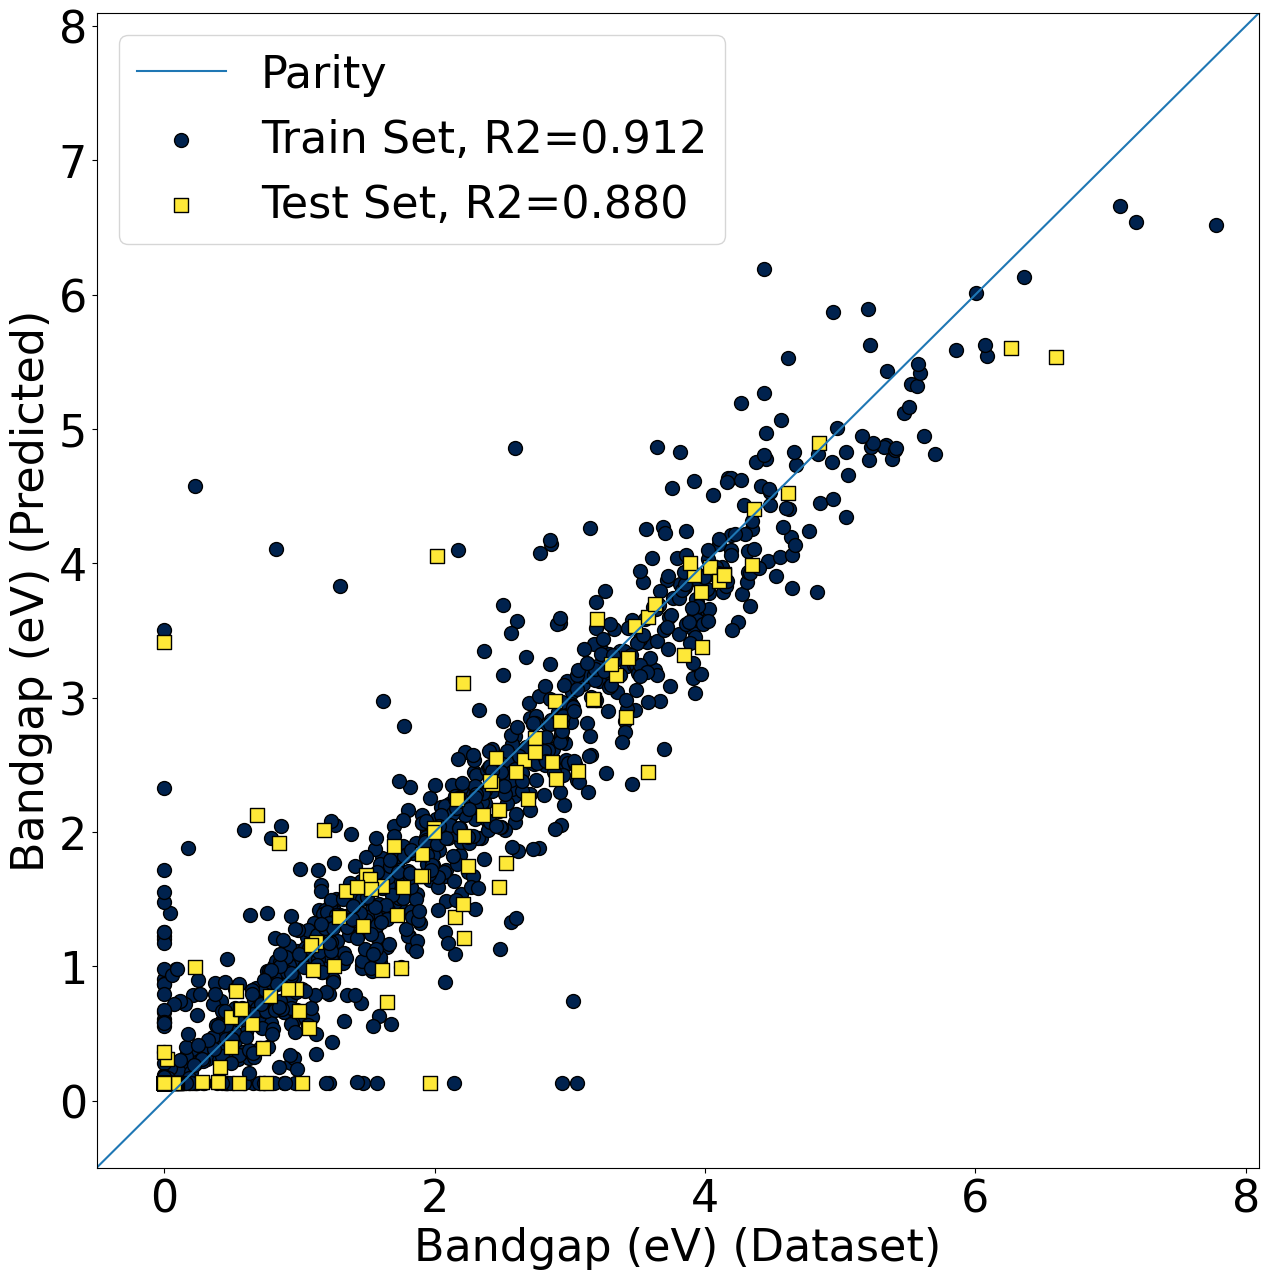

In [22]:
DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(
                                    train_y_true = model.prop_train,
                                    train_y_pred =  model.fit,
                                    test_y_true = test_sisso['bandgap (eV)'],
                                    test_y_pred = p_est,
                                    axis_label = "Bandgap (eV)",
                                    axis_limits=[-0.5, 8.1],
                                    filename = "sisso_2dm_bandgap_parity_updated.png")

In [23]:
train_preds = train[target_column]
train_preds['TrainTest Status'] = ['Training Set'] * len(train_preds)
train_preds['Prediction'] = model.fit

test_preds = test[target_column]
test_preds['TrainTest Status'] = ['Test Set'] * len(test_preds)
test_preds['Prediction'] = p_est

sisso_predictions = train_preds.append(test_preds)
sisso_predictions.to_csv("sisso_update_mp/sisso_2dm_bandgap_predictions.csv")

# Original SISSO LASO Selection Results

In [ ]:
sisso_feature_selector = sklearn.feature_selection.SelectFromModel(sklearn.linear_model.LassoCV(random_state=RANDOM_SEED),
                                                                   threshold=-np.inf,
                                                                   max_features=16,
                                                                   prefit=False)
sisso_feature_selector.fit(train_x, train_y.ravel())

sisso_features = [col for (col, is_selected) in zip(train[descriptors].columns, sisso_feature_selector.get_support()) if is_selected]
print("\n".join(sisso_features))

In [ ]:
sisso_dir = "./sisso"
os.makedirs(sisso_dir, exist_ok=True)

sisso_data_train = train[target_column + sisso_features]
sisso_data_test = test[target_column + sisso_features]

sisso_data_train.to_csv(os.path.join(sisso_dir, 'sisso_train.csv'), index_label='2dm_id (unitless)')
sisso_data_test.to_csv(os.path.join(sisso_dir, 'sisso_test.csv'), index_label='2dm_id (unitless)')

At this point, a SISSO model was run. The models are stored below.

The model forms are from the SISSO logfiles. For example, the "r1_1term" model corresponds with the 1-term model from rung 1.

The coefficients are extracted from the generated model `.dat` files, found in the `sisso/models` directory. 

In [ ]:
sisso_models = {
    'r1_1term': lambda df: 5.865590038114292e+00 + \
                           -4.133268583136611e-01 * (np.cbrt(df['ave:boiling_point'])),
    
    'r1_2term': lambda df: 5.456824304436886e+00 + \
                           5.806272825102222e-05 * (df['var:sound_velocity'] / df['ave:boiling_point']) + \
                           -3.928478305199087e-01 * (np.cbrt(df['ave:boiling_point'])),
    
    'r1_3term': lambda df: 5.829318713354136e+00 + \
                           -2.895404136895635e-02 * (df['var:thermal_conductivity'] / df['ave:boiling_point']) + \
                           5.661787713744031e-05 * (df['var:sound_velocity'] / df['ave:boiling_point']) + \
                           -4.133601815903408e-01 * (np.cbrt(df['ave:boiling_point'])),
    
    'r1_4term': lambda df: 4.239649765792811e+00 + \
                           3.209844715367811e-04 * (df['sum:hhi_p'] / df['ave:atomic_weight']) + \
                           -2.931356075881642e-02 * (df['var:thermal_conductivity'] / df['ave:boiling_point']) + \
                           5.565612620549401e-06 * (df['var:sound_velocity'] / df['ave:atomic_radius_rahm']) + \
                           -8.322616418822797e-02 * (np.sqrt(df['ave:boiling_point'])),
    
    'r2_1term': lambda df: -6.848927418726274e-01 + \
                           1.020330482802878e+00 * ((abs(df['ave:atomic_volume'] - df['ave:Polarizability'])) / (np.sqrt(df['ave:atomic_number']))),
    
    'r2_2term': lambda df: -7.037029355457204e-01 + \
                           -1.319062598081636e-03 * ((df['var:thermal_conductivity'] * df['ave:bulk_modulus']) / (df['ave:boiling_point'] * df['ave:Polarizability'])) + \
                           1.084886105825630e+00 * ((abs(df['ave:atomic_volume'] - df['ave:Polarizability'])) / (np.sqrt(df['ave:atomic_number']))),
    
    'r2_3term': lambda df: 1.288364460133121e+00 + \
                           -4.685654009911847e-02 * ((df['ave:atomic_number'] / df['ave:atomic_weight']) * (df['ave:atomic_radius_rahm'] - df['ave:atomic_radius'])) + \
                           -3.019449625791471e-05 * ((df['var:thermal_conductivity'] * df['var:boiling_point']) / (df['ave:boiling_point']**2)) + \
                           1.284011701624066e+00 * ((abs(df['ave:atomic_volume'] - df['ave:Polarizability'])) / (np.sqrt(df['ave:atomic_weight']))),
    
    'r2_4term': lambda df: 1.264193645822197e+00 + \
                           1.670730994972521e+01 * ((np.cbrt(df['var:thermal_conductivity'])) / (df['ave:bulk_modulus'] * df['ave:atomic_volume'])) + \
                           -5.358316290237519e-02 * ((df['ave:atomic_number'] / df['ave:atomic_weight']) * (df['ave:atomic_radius_rahm'] - df['ave:atomic_radius'])) + \
                           -3.794450825704627e-05 * ((df['var:thermal_conductivity'] * df['var:boiling_point']) / (df['ave:boiling_point']**2)) + \
                           1.281828774755674e+00 * ((abs(df['ave:atomic_volume'] - df['ave:Polarizability'])) / (np.sqrt(df['ave:atomic_weight'])))
}

for key, fun in sisso_models.items():
    print(f"==========\nSISSO Model {key}")
    sisso_train_predictions = fun(sisso_data_train)
    sisso_test_predictions = fun(sisso_data_test)
    sisso_data_train[key] = sisso_train_predictions
    sisso_data_test[key] = sisso_test_predictions
    
    print("\nTest Set Error Metrics")
    for metric, fun in metrics.items():
        value = fun(y_true=sisso_data_test['bandgap (eV)'], y_pred=sisso_test_predictions)
        print(metric,np.round(value,4))

    print("\nTraining Set Error Metrics")
    for metric, fun in metrics.items():
        value = fun(y_true=sisso_data_train['bandgap (eV)'], y_pred=sisso_train_predictions)
        print(metric,np.round(value,4))
    
    


Finally, we'll go ahead and save the predictions of the SISSO model on the training and test set.

In [ ]:
sisso_data_train.to_csv(os.path.join(sisso_dir, 'sisso_results_train.csv'))
sisso_data_test.to_csv(os.path.join(sisso_dir, 'sisso_results_test.csv'))

In [ ]:
model_to_plot = 'r2_4term'
DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(train_y_true = sisso_data_train['bandgap (eV)'],
                                                                    train_y_pred = sisso_data_train[model_to_plot],
                                                                    test_y_true = sisso_data_test['bandgap (eV)'],
                                                                    test_y_pred = sisso_data_test[model_to_plot],
                                                                    axis_label = "Bandgap (eV)",
                                                                    filename = "sisso_2dm_bandgap_parity.jpeg")

Finally, just so we have them, let's print out the rest of the SISSO models

In [ ]:
for model_to_plot in sisso_models.keys():
    DigitalEcosystem.utils.figures.save_parity_plot_publication_quality(train_y_true = sisso_data_train['bandgap (eV)'],
                                                                        train_y_pred = sisso_data_train[model_to_plot],
                                                                        test_y_true = sisso_data_test['bandgap (eV)'],
                                                                        test_y_pred = sisso_data_test[model_to_plot],
                                                                        axis_label = "Bandgap (eV)",
                                                                        title=f'SISSO Rung-{model_to_plot[1]}, {model_to_plot[3]}-term Model')

In [ ]:
import scipy

for i in [imp[1] for imp in sorted_importances[:5]]:
    print(i)
    print(scipy.stats.pearsonr(x=np.nan_to_num(data[i].to_numpy()), y=data['bandgap (eV)']))
    print(scipy.stats.spearmanr(a=np.nan_to_num(data[i].to_numpy()), b=data['bandgap (eV)']))
    print('========')

# Plotting parity plots

In [24]:
# Plot Configuration
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["font.size"] = 10

xgboost_pred = pd.read_csv("xgboost/xgboost_2dm_bandgap_predictions.csv", index_col=0)
tpot_pred = pd.read_csv("tpot/tpot_2dm_bandgap_predictions.csv", index_col=0)

roost_train_results = pd.read_csv("roost/roost_train_predictions.csv", index_col="material_id")
roost_test_results  = pd.read_csv("roost/roost_test_predictions.csv", index_col="material_id")

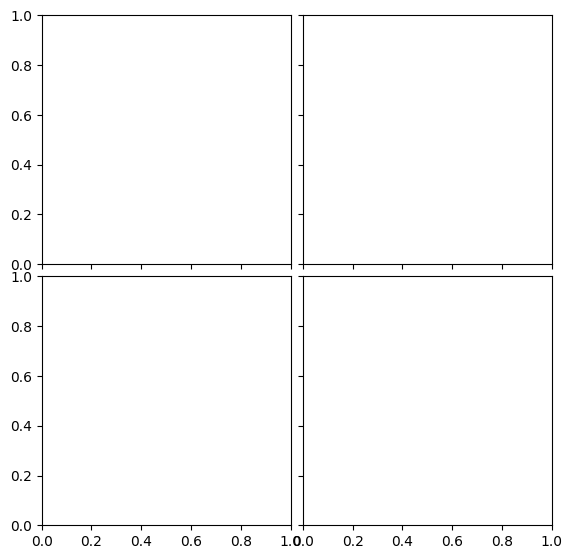

In [25]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(
    nrows=2,
    ncols=2,
    sharex=True,
    sharey=True,
)

fig.subplots_adjust(
    top=0.95, bottom=0.10, left=0.12, right=0.97, wspace=0.05,  hspace=0.05
)

In [26]:
def plot_parity_plot_publication_quality(
    train_y_true,
    train_y_pred,
    test_y_true,
    test_y_pred,
    axis_label,
    ax,
    filename=None,
    axis_limits=None,
    title=None,
):
    ax.clear()
    n_series = 2
    cmap = iter(plt.cm.cividis(np.linspace(0, 1, n_series)))

    train_r2 = np.round(
        sklearn.metrics.r2_score(y_true=train_y_true, y_pred=train_y_pred), 3
    )
    test_r2 = np.round(
        sklearn.metrics.r2_score(y_true=test_y_true, y_pred=test_y_pred), 3
    )

    ax.scatter(
        x=train_y_true,
        y=train_y_pred,
        label="Train R2=%.3f" % train_r2,
        color=next(cmap),
        s=15,
        marker="o",
        lw=1,
        edgecolor="black",
    )
    ax.scatter(
        x=test_y_true,
        y=test_y_pred,
        label="Test R2=%.3f" % test_r2,
        color=next(cmap),
        s=15,
        marker="s",
        lw=1,
        edgecolor="black",
    )

    if title:
        ax.title(title)
    ax.legend(frameon=False, loc="upper left", handlelength=1)


In [27]:
plot_parity_plot_publication_quality(
    train_y_true = model.prop_train,
    train_y_pred =  model.fit,
    test_y_true = test_sisso['bandgap (eV)'],
    test_y_pred = p_est,
    ax = ax4,
    axis_label = "Bandgap (eV)",
)

In [28]:
plot_parity_plot_publication_quality(
    train_y_true = roost_train_results['bandgap_target'],
    train_y_pred =  roost_train_results['bandgap_pred_n0'],
    test_y_true = roost_test_results['bandgap_target'],
    test_y_pred = roost_test_results['bandgap_pred_n0'],
    ax=ax3,
    axis_label = "Bandgap (eV)",
)

In [29]:
topt_train_results = tpot_pred.loc[tpot_pred["TrainTest Status"] == "Training Set", ["bandgap (eV)", "Prediction"]]
topt_test_results = tpot_pred.loc[tpot_pred["TrainTest Status"] == "Test Set", ["bandgap (eV)", "Prediction"]]

plot_parity_plot_publication_quality(
    train_y_true = topt_train_results["bandgap (eV)"],
    train_y_pred =  topt_train_results["Prediction"],
    test_y_true = topt_test_results["bandgap (eV)"],
    test_y_pred = topt_test_results["Prediction"],
    ax=ax2,
    axis_label = "Bandgap (eV)",
)

In [30]:
xgboost_train_results = xgboost_pred.loc[xgboost_pred["TrainTest Status"] == "Training Set", ["bandgap (eV)", "Prediction"]]
xgboost_test_results = xgboost_pred.loc[xgboost_pred["TrainTest Status"] == "Test Set", ["bandgap (eV)", "Prediction"]]

plot_parity_plot_publication_quality(
    train_y_true = xgboost_train_results["bandgap (eV)"],
    train_y_pred = xgboost_train_results["Prediction"],
    test_y_true = xgboost_test_results["bandgap (eV)"],
    test_y_pred = xgboost_test_results["Prediction"],
    ax=ax1,
    axis_label = "Bandgap (eV)",
)

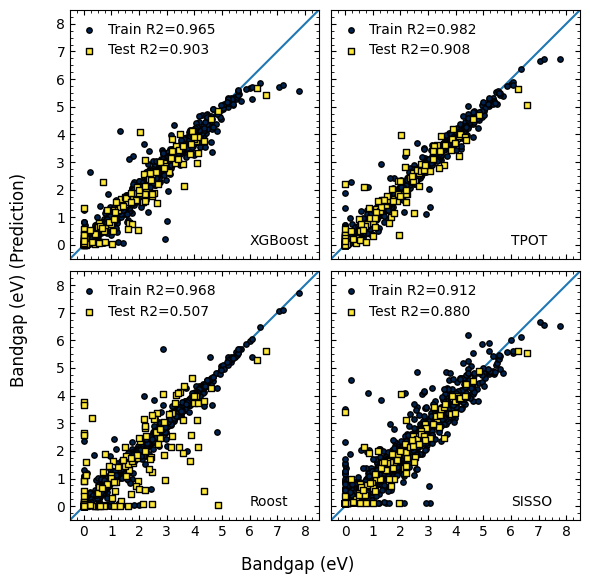

In [31]:
lims = [-0.5, 8.5]
ticks = range(0, 9, 1)
mticks = np.arange(-0.5, 8.51, 0.25)

labels = ["XGBoost", "TPOT", "Roost", "SISSO"]
for aa, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.tick_params(direction="in", which="both", right=True, top=True)
    ax.plot(lims, lims, zorder=-1)
    ax.text(6, 0.0, labels[aa])

ax1.set_xlim(lims)
ax1.set_ylim(lims)

ax1.set_xticks(ticks)
ax1.set_yticks(ticks)

ax1.set_xticks(mticks, minor=True)
ax1.set_yticks(mticks, minor=True)

fig.supxlabel('Bandgap (eV)')
fig.supylabel('Bandgap (eV) (Prediction)')
fig.savefig("2dm_bandgap_parity.pdf")
fig